In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import os
import matplotlib.ticker as ticker
from adjustText import adjust_text
import copy
import statistics
import pandas as pd
from itertools import chain
c=299792458

#—————————————————数据导入————————————————————

# 导入光谱数据文件
def open_file():
    path='C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\spw1'  #设置存储路径
    files= os.listdir(path) #得到文件夹下的所有文件名称
    name_list=source_name(files) # 得到每个源的名字
    data=[]  # 建立空列表储存数据
    data_i=0 # 记录是第几个文件

    for file in files:  #按照顺序在 files 里面进行每一个文件的 数据名称 循环读取
        position = path+"\\"+file   # 打开第一个文件
        data.append([])
        with open(position, 'r') as f:
            line_num=0
            for line in f:
                if line_num>0:
                    data[data_i].append(line.strip().split())
                line_num+=1
        data_i+=1
    return data,name_list

# 导入源速度
file_path = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\CO_and_HCO\\source.vsys.dat"
import pandas as pd

# 假设文件格式：
# 列名: ID   Vsys   RA    Dec
# 数据: 001  250.3  12.5  30.0
# 注释行以 '#' 开头

df = pd.read_csv(
    file_path,
    sep='\s+',          # 按空格/制表符分隔
    comment='#',        # 忽略注释行
    header=0,           # 第一行为列名
    #names=['ID', 'Vsys', 'RA', 'Dec']  # 可选：手动指定列名
)

# print(df)   # df.head()则默认输出前五行数据，在数据量大的时候可以方便检查
dic_v = dict(zip(df['source,'],df['Vsys,']))   # 把csv文件转成字典


# 导入所有谱线的信息
file_path = "C:/Users/zyx/Desktop/Spectral with Machine Learning/data/linelist.txt"

# 假设文件格式：
# 列名: ID   Vsys   RA    Dec
# 数据: 001  250.3  12.5  30.0
# 注释行以 '#' 开头

df_spectrum = pd.read_csv(
    file_path,
    sep='\s+',          # 按空格/制表符分隔
    #comment='#',        # 忽略注释行
    header=0,           # 第一行为列名
    #names=['ID', 'Vsys', 'RA', 'Dec']  # 可选：手动指定列名
)

# print(df_spectrum) 
spectrum_name=df_spectrum.iloc[:,0].tolist()
spectrum_fre=df_spectrum.iloc[:,1].tolist()

In [14]:
print(spectrum_fre)

[345.3385391, 345.3387862, 345.4489815, 346.5238776, 346.6521672, 344.2453476, 344.581045, 344.8079157, 344.9875851, 344.9981616, 345.168666, 345.2856217, 345.5196584, 345.5530949, 345.6512957, 345.6787895, 345.9292848, 344.310612, 346.528481, 347.740011, 345.7959899, 347.330631, 346.998344, 344.443433, 345.903916, 345.91926, 346.202719, 344.3580659, 344.5153801, 345.030561, 346.718858, 346.7584855, 344.2003199, 345.60901, 345.5846957, 346.5900976, 346.220137, 346.3791906, 347.188283, 345.718662, 356.7551893, 357.16536, 357.24119, 357.38757, 357.5814483, 357.67178, 357.892442, 357.92596, 357.96289, 358.01309, 358.03808, 358.21564, 359.151156, 359.7706815, 357.1021822, 357.4977581, 358.3473131, 358.9879745, 356.734223, 358.414648, 358.605799, 357.4602017, 358.4519426, 356.65842723, 359.58010263]


In [2]:
#————————————————谱线处理————————————————

# 获取源名字
def source_name(name):
    name_list=[]
    for i in range(len(name)):
        part=name[i].split(".")
        name_list.append(part[1])
    return name_list

# 输入某一个文件的数据，转换成xy
def data_to_xy(data):   
    data_x=[]
    data_y=[]
    for i in range(len(data)):
        data_x.append(float(data[i][0]))
        data_y.append(float(data[i][1]))
    return data_x,data_y

# 放大谱线
def enlarge2(peak_list,x,y,v):
    large_peak_list_x=[]    #放大后的谱线
    large_peak_list_y=[]
    data_x=np.array(x)
    data_x_real=data_x/(1-(v*10e3/(3.0*10e8)))   # 把频率的红移/蓝移移回来
    #data_x_real=[float('{:.8f}'.format(j)) for j in data_x_real]

    for i in range(len(peak_list)):
        if peak_list[i]<=45:
            data_x=data_x_real[0:peak_list[i]+45]
            data_y=y[0:peak_list[i]+45]
            #print("在前端")
        elif peak_list[i]+45>=len(data_x_real):
            data_x=data_x_real[peak_list[i]-45:len(data_x_real)]
            data_y=y[peak_list[i]-45:len(data_x_real)]
            #print("在后端")
        else:
            data_x=data_x_real[peak_list[i]-45:peak_list[i]+45]
            #print(data_x)
            data_y=y[peak_list[i]-45:peak_list[i]+45]
            #print(data_y)
            #print("刚好在中间")
            
        large_peak_list_x.append(data_x)
        large_peak_list_y.append(data_y)
        
        #paint(data_x,data_y)
    return large_peak_list_x,large_peak_list_y

# 归一化
def guiyihua(list5):
    a_max=max(list5)
    list6=[]
    for i in range(len(list5)):
        list6.append(list5[i]/a_max)
    return list6

In [3]:
# 用直方图求误差

def gaussian(x, amp, mean, std):
    """高斯函数定义"""
    return amp * np.exp(-((x - mean) ** 2) / (2 * std ** 2))

def histogram_ds(y):
    data_y = np.array(y)
    print(f"数据统计: 最小值={np.min(data_y):.4f}, 最大值={np.max(data_y):.4f}, 均值={np.mean(data_y):.4f}")
    
    # ============ 1. 数据预处理和直方图计算 ============
    plt.figure(figsize=(10, 6))
    
    # 动态调整分箱数量和范围
    data_range = np.max(data_y) - np.min(data_y)
    bin_count = min(100, len(data_y)//10)  # 根据数据量动态调整分箱数
    bins = np.linspace(
        np.min(data_y) - 0.01 * data_range,
        np.max(data_y) + 0.01 * data_range,
        bin_count
    )
    
    counts, bin_edges, _ = plt.hist(
        data_y, 
        bins=bins, 
        density=True,
        alpha=0.7, 
        color='skyblue',
        edgecolor='white',
        label='Histogram'
    )
    
    # 计算分箱中心点（使用整个数据范围）
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # ============ 2. 改进的高斯拟合 ============
    print("------------------------开始拟合---------------------")
    
    # 更智能的初始参数估计
    peak_idx = np.argmax(counts)
    peak_value = counts[peak_idx]
    peak_center = bin_centers[peak_idx]
    
    # 计算标准差时使用峰值附近的点
    half_max_idx = np.where(counts > peak_value/2)[0]
    if len(half_max_idx) > 1:
        std_estimate = (bin_centers[half_max_idx[-1]] - bin_centers[half_max_idx[0]]) / 2.355
    else:
        std_estimate = data_range / 10  # 回退估计
    
#     std_estimate=np.std(data_y)
    
    initial_guess = [peak_value, peak_center, max(std_estimate, 0.01)]
    print(f"初始估计: 幅度={initial_guess[0]:.4f}, 均值={initial_guess[1]:.4f}, 标准差={initial_guess[2]:.4f}")
    
    # 动态设置边界（基于数据范围）
    data_range = np.max(data_y) - np.min(data_y)
    bounds = (
        [0.1 * peak_value, peak_center - 2*data_range, 0.001],  # 下界
        [10 * peak_value, peak_center + 2*data_range, 10*data_range]  # 上界
    )
    
    try:
        # 使用更鲁棒的优化方法
        params, params_cov = curve_fit(
            gaussian,
            bin_centers,
            counts,
            p0=initial_guess,
            bounds=bounds,
            method='trf',  # 使用TRF算法处理边界
            maxfev=50000,
            ftol=1e-5,      # 放宽收敛容差
            xtol=1e-5
        )
        
        amp, mean, std = params
        print(f"拟合成功: 幅度={amp:.4f}, 均值={mean:.4f}, 标准差={std:.4f}")
        
        # 生成拟合曲线
        x_fit = np.linspace(np.min(bin_centers), np.max(bin_centers), 500)
        y_fit = gaussian(x_fit, amp, mean, std)
        
        # ============ 3. 绘制结果 ============
        #plt.ylim(0,10)
        plt.plot(x_fit, y_fit, 'r-', linewidth=2.5, label=f'Gaussian Fit (σ={std:.4f})')
        plt.axvline(mean, color='green', linestyle='--', label=f'Mean: {mean:.4f}')
        plt.title(f'Histogram and Gaussian Fit ')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
        
        return std
    
    except Exception as e:
        print(f"!!! 拟合失败: {str(e)}")
        plt.title("Histogram (Fit Failed)")
        plt.show()
        return None, None

In [4]:
# 导入数据以及名字
data,name_list=open_file()
target_name=['Lh07','Lh09','Lh10']

数据统计: 最小值=-0.0160, 最大值=0.0499, 均值=0.0018
------------------------开始拟合---------------------
初始估计: 幅度=157.1349, 均值=0.0007, 标准差=0.0100
拟合成功: 幅度=156.1263, 均值=0.0002, 标准差=0.0023


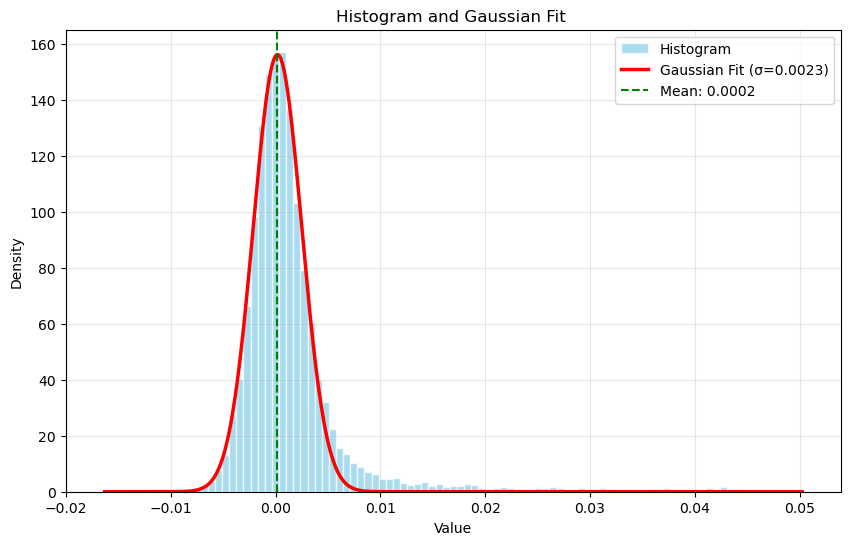

数据统计: 最小值=-0.0140, 最大值=0.0499, 均值=0.0009
------------------------开始拟合---------------------
初始估计: 幅度=177.9832, 均值=0.0002, 标准差=0.0100
拟合成功: 幅度=177.9848, 均值=0.0001, 标准差=0.0021


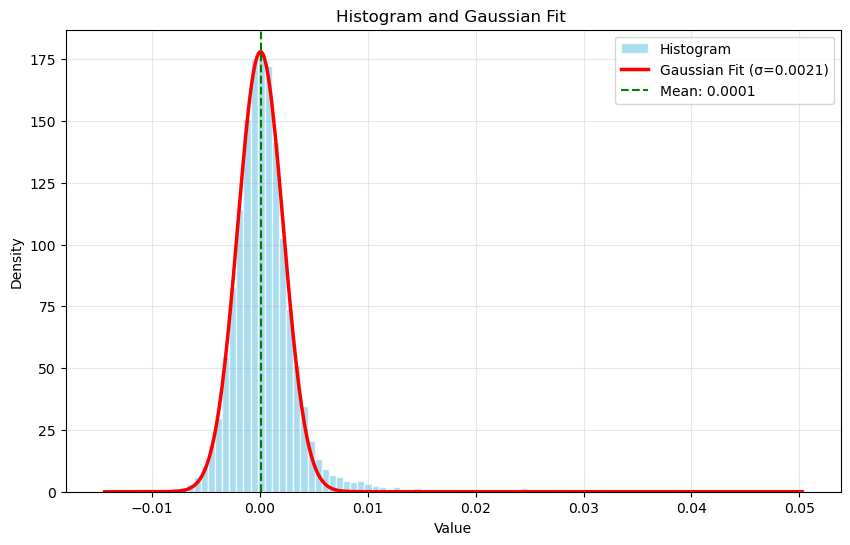

数据统计: 最小值=-0.0168, 最大值=0.0499, 均值=0.0009
------------------------开始拟合---------------------
初始估计: 幅度=186.9692, 均值=0.0001, 标准差=0.0100
拟合成功: 幅度=180.6665, 均值=0.0000, 标准差=0.0021


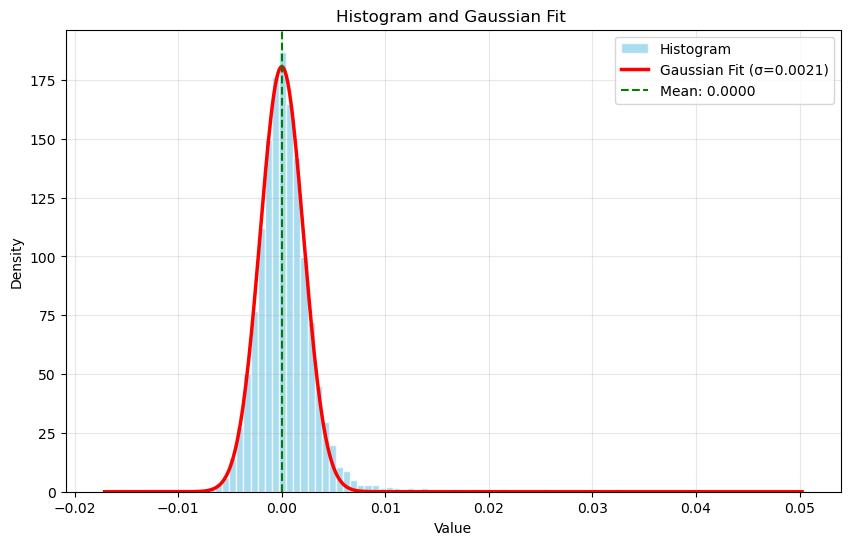

In [5]:
# 把五个spw合并，用直方图求标准差
spw_std=[]
for n in range(len(target_name)):
    all_spectrum=[]
    filter_spectrum=[]
    for i in range(len(data)):
        if name_list[i]==target_name[n]:
            x,y=data_to_xy(data[i])
            all_spectrum.extend(y)
    filter_spectrum=[x for x in all_spectrum if x<=0.05]
    std=histogram_ds(filter_spectrum)
    spw_std.append(std)

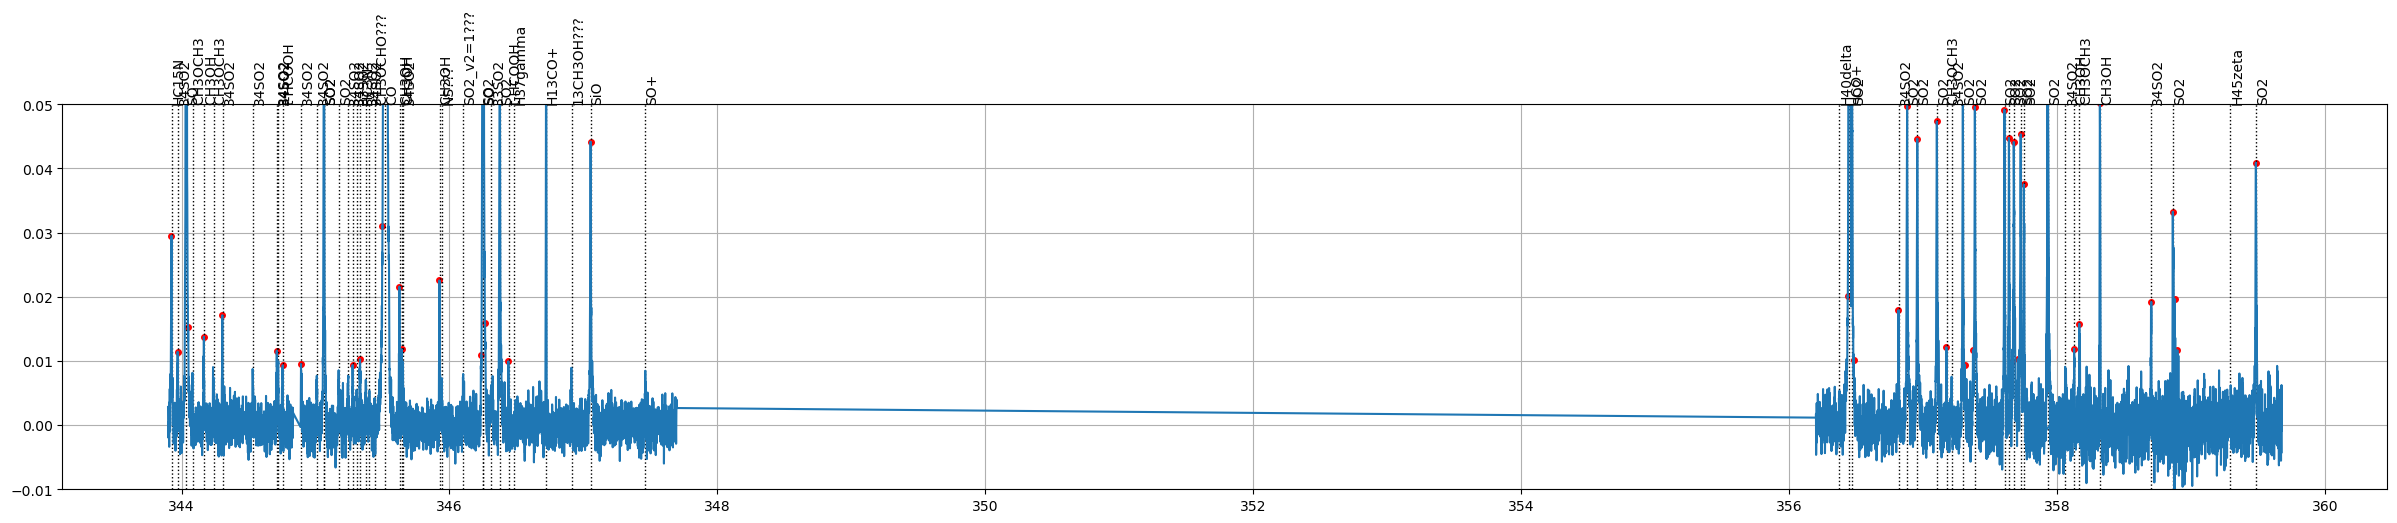

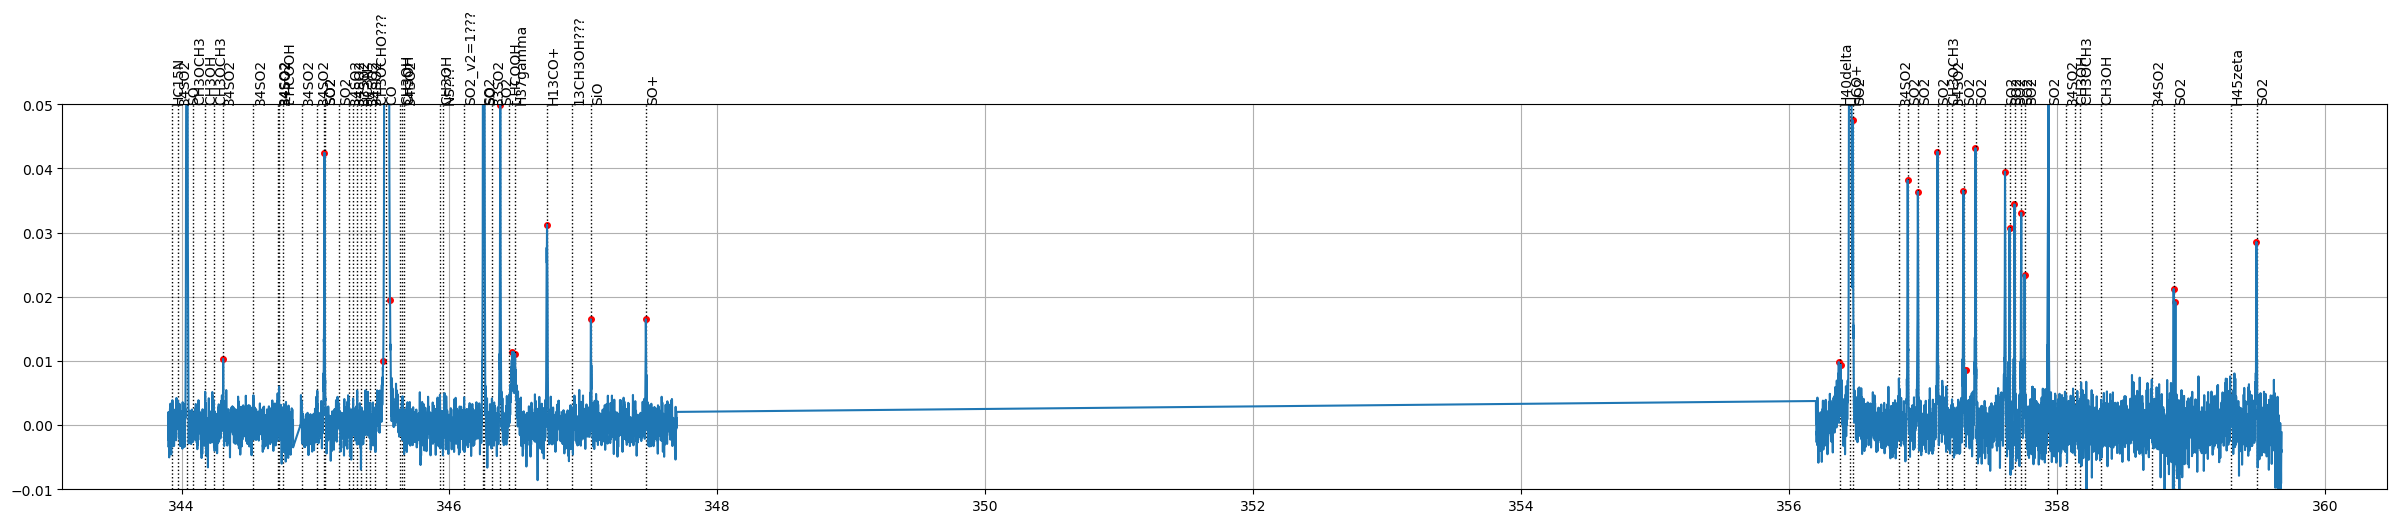

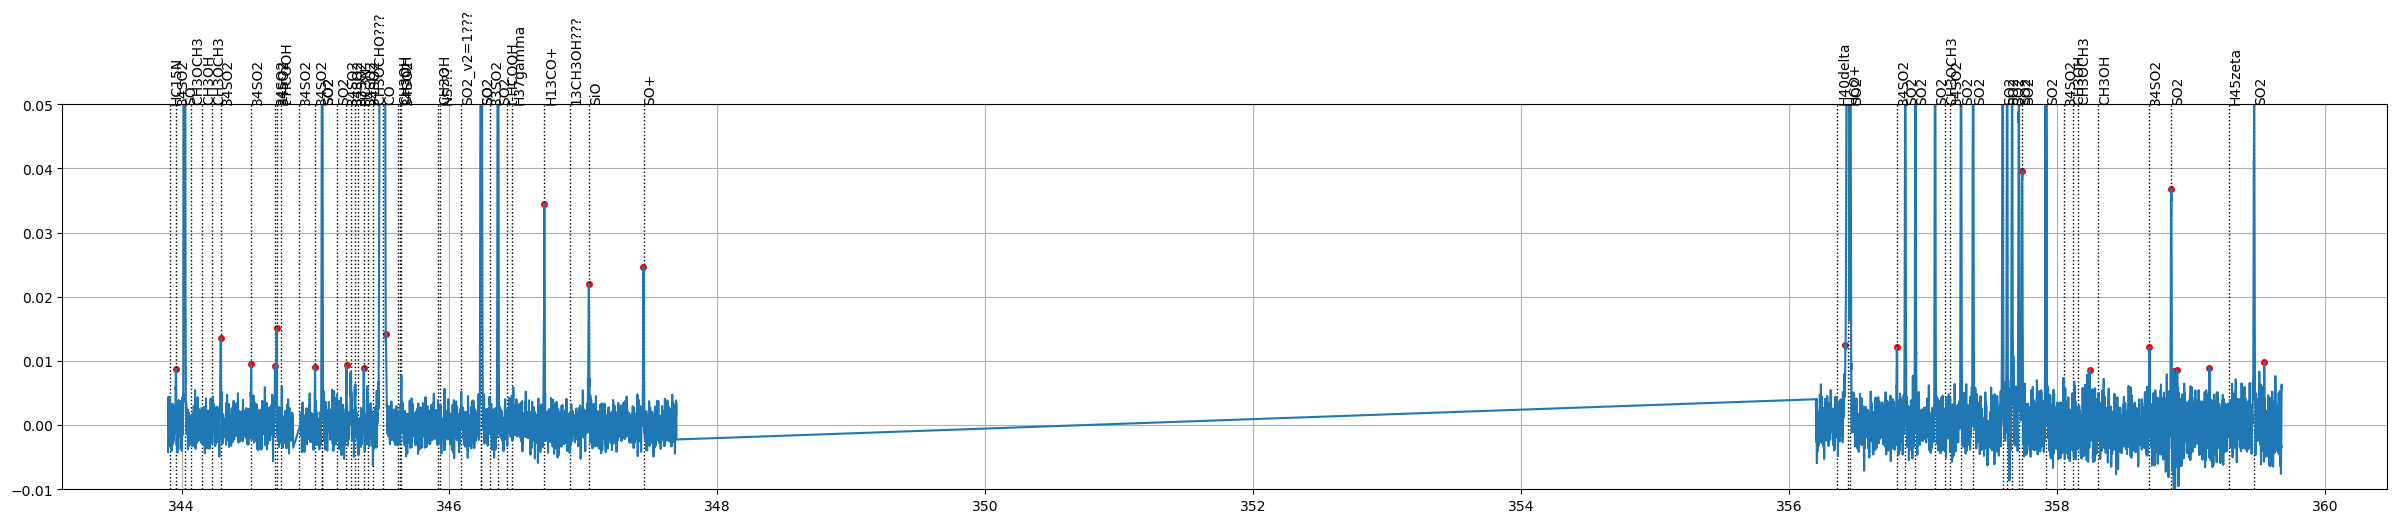

In [6]:
# 将标准谱线与数据对比，寻找峰值
    
target_x=[[] for i in range(3)]  # 把源的x和y提出来，一个[]装一个源的所有谱线的数据
target_y=[[] for i in range(3)] 
peak_list=[] 

for n in range(len(target_name)):
    
    for i in range(len(data)):
        if name_list[i]==target_name[n]:
            x,y=data_to_xy(data[i])
            target_x[n].extend(x)
            target_y[n].extend(y)
    peaks, properties = find_peaks(target_y[n], height=4*spw_std[n],distance=25)
    peak_list.append(list(peaks))
    
    plt.figure(figsize=(30,5))
    plt.ylim(-0.01,0.05)
    plt.grid()
    for j in range(len(peaks)):
        plt.plot(target_x[n][peaks[j]],target_y[n][peaks[j]],marker='o',color='red',markersize=4)
    
    # 获取视向速度
    target_velocity=dic_v[target_name[n]]
    # 把静止频率修正
    spectrum_fre_v=[]
    for i in range(len(spectrum_fre)):
        spectrum_fre_v.append(spectrum_fre[i]*(1-target_velocity*10e3/(3.0*10e8)))
    
    
    for j in range(len(spectrum_name)):
        plt.axvline(x=spectrum_fre_v[j], color="black", linestyle=":", linewidth=1) # 标准谱线已根据速度修正
        plt.text(
            spectrum_fre_v[j],  # 文本X位置（竖线右侧）
            0.05,  # 文本Y位置
            spectrum_name[j], 
            rotation=90,  # 垂直旋转
            color="black",
            va="bottom"   # 垂直对齐
            )
    plt.plot(target_x[n],target_y[n])
    plt.show()
    

In [7]:
# 把谱线挑出来放大
x_large=[]       
y_large=[]
for i in range(len(peak_list)):
    x_large_tem,y_large_tem=enlarge2(peak_list[i],target_x[i],target_y[i],dic_v[target_name[i]])
    x_large.append(x_large_tem)
    y_large.append(y_large_tem)

Lh07_HC15N
0-0


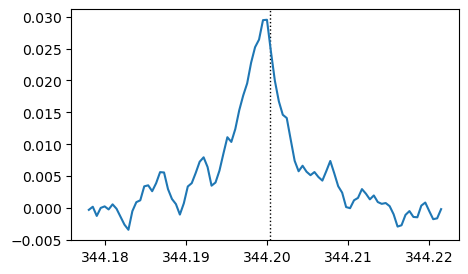

Lh07_34SO2
0-1


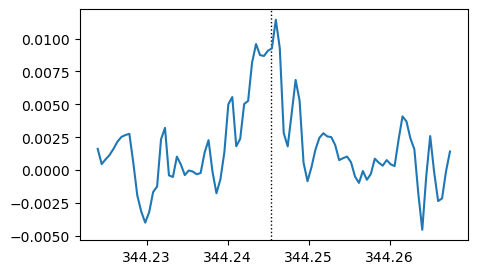

Lh07_SO
0-2


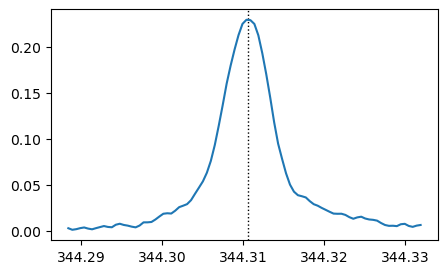

Lh07_SO
0-3


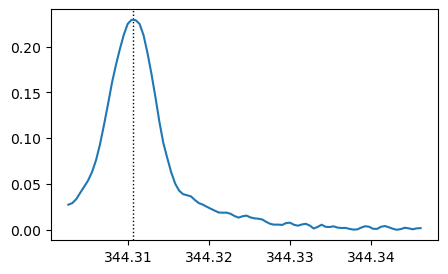

Lh07_CH3OH
0-4


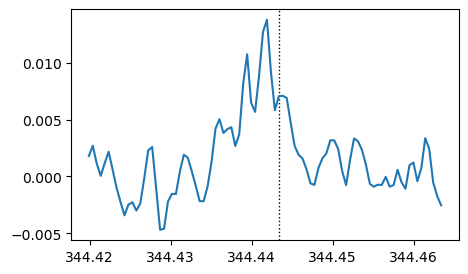

Lh07_34SO2
0-5


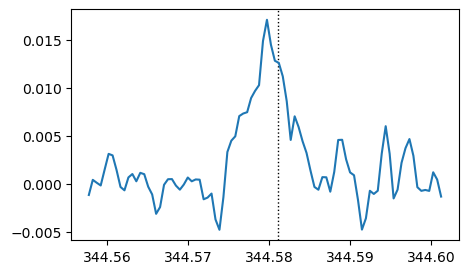

Lh07_34SO2
0-6


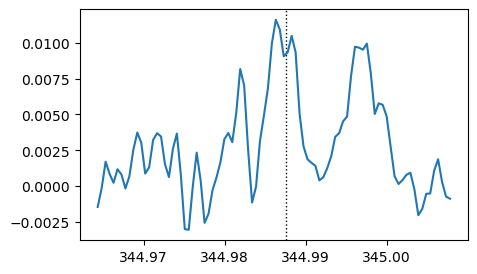

Lh07_t-HCOOH
0-7


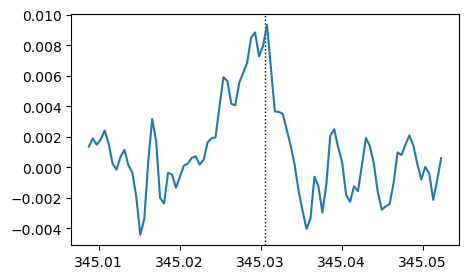

Lh07_34SO2
0-8


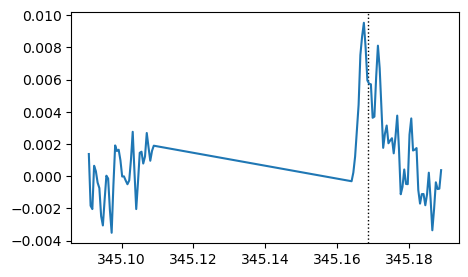

Lh07_SO2
0-9


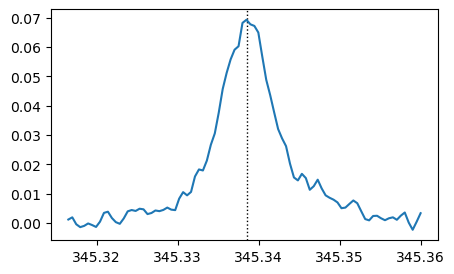

Lh07_34SO2
0-10


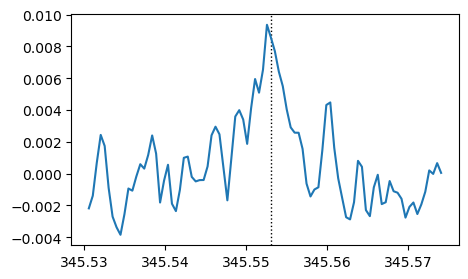

Lh07_HC3N
0-11


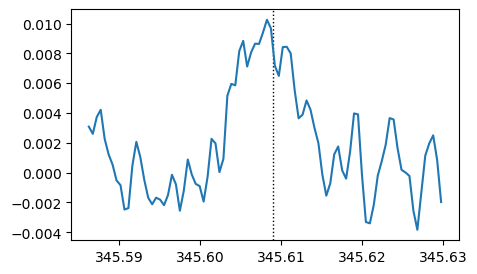

Lh07_CO
0-12


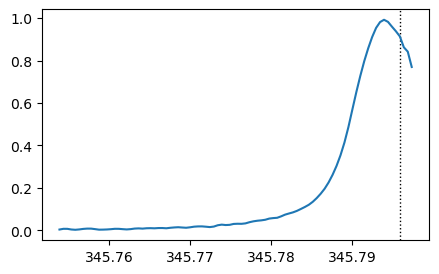

Lh07_CO
0-13


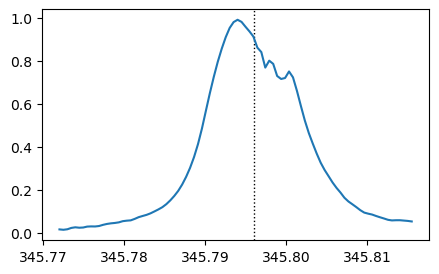

Lh07_CO
0-14


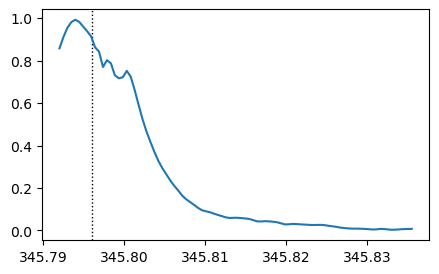

Lh07_CH3OH
0-15


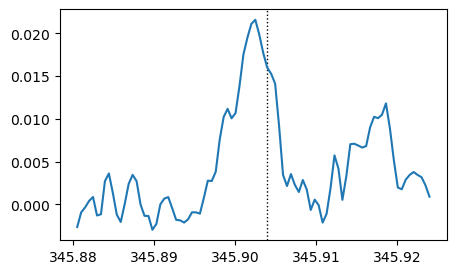

Lh07_CH3OH
0-16


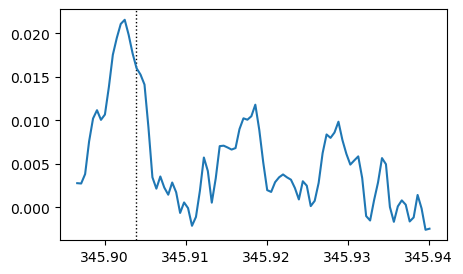

Lh07_CH3OH
0-17


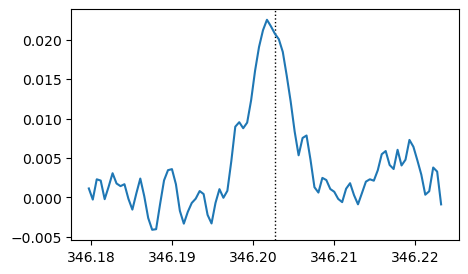

Lh07_SO
0-18


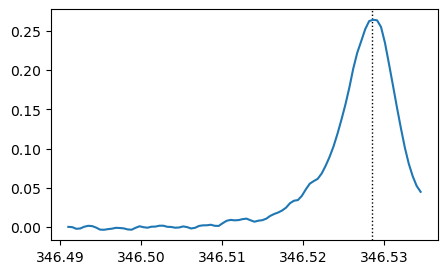

Lh07_SO
0-19


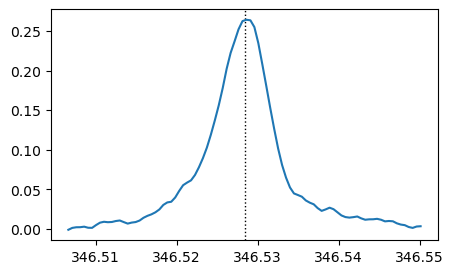

Lh07_SO
0-20


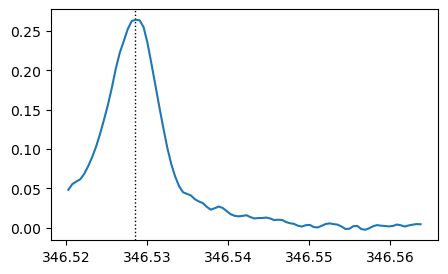

Lh07_SO2
0-21


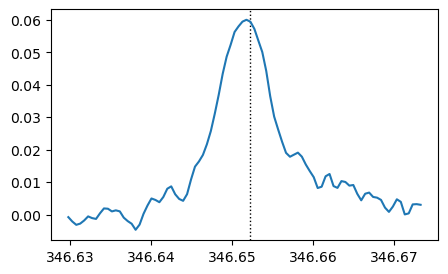

Lh07_t-HCOOH
0-22


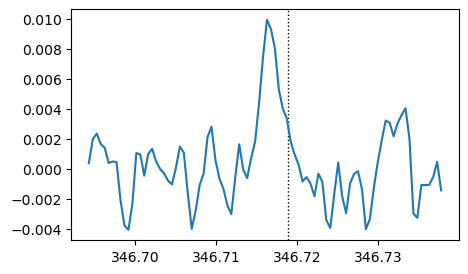

Lh07_H13CO+
0-23


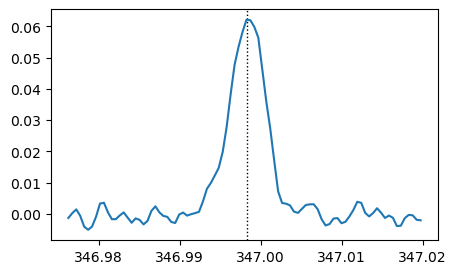

Lh07_SiO
0-24


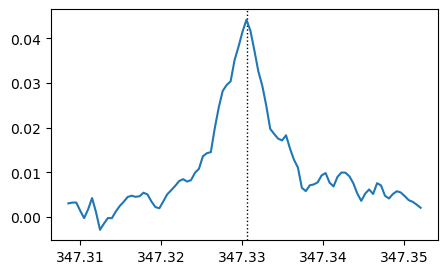

Lh07_HCO+
0-25


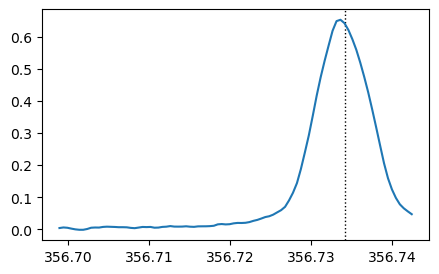

Lh07_HCO+
0-26


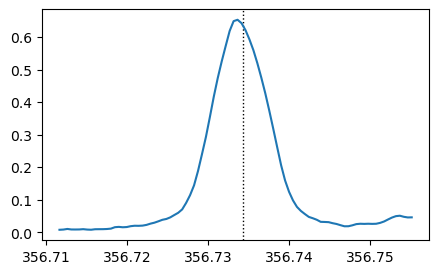

Lh07_HCO+
0-27


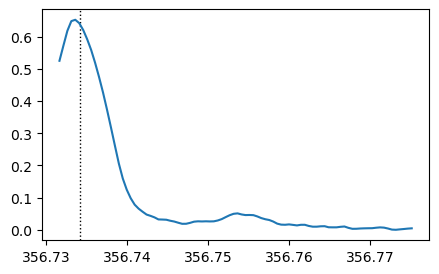

Lh07_SO2
0-28


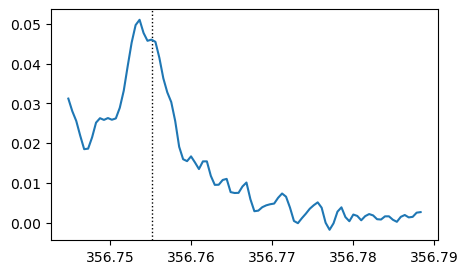

Lh07_34SO2
0-29


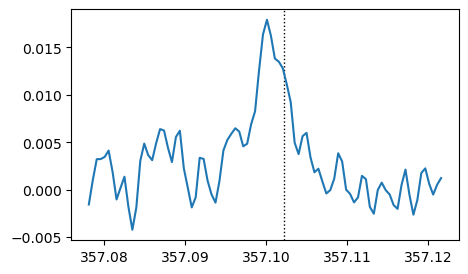

Lh07_SO2
0-30


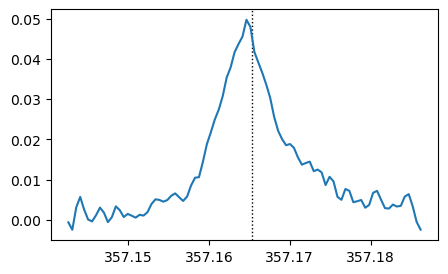

Lh07_SO2
0-31


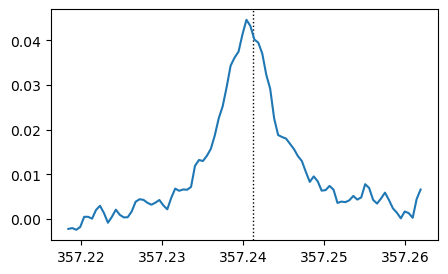

Lh07_SO2
0-32


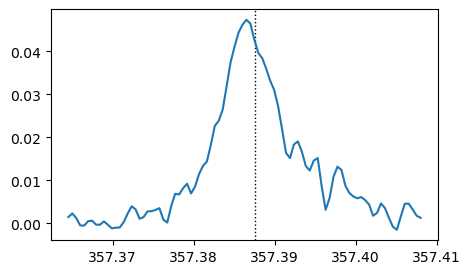

Lh07_CH3OCH3
0-33


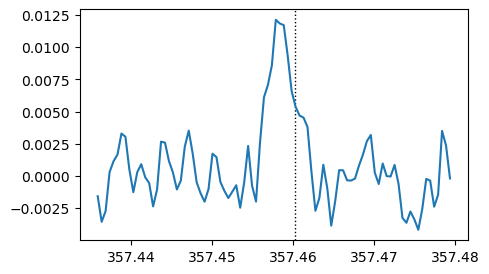

Lh07_SO2
0-34


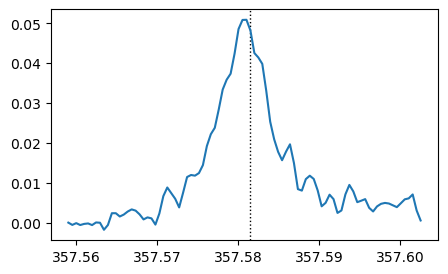

Lh07_SO2
0-35


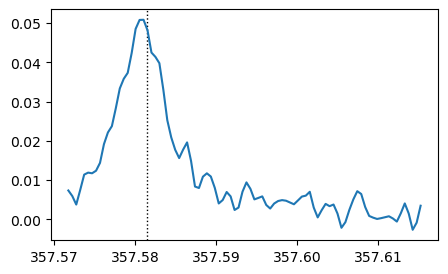

Lh07_SO2
0-36


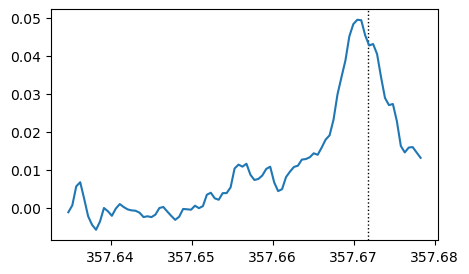

Lh07_SO2
0-37


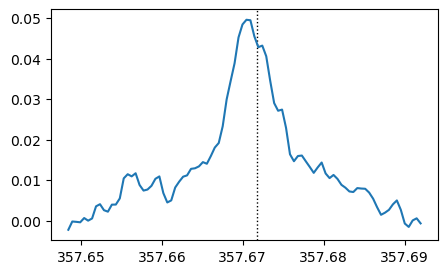

Lh07_SO2
0-38


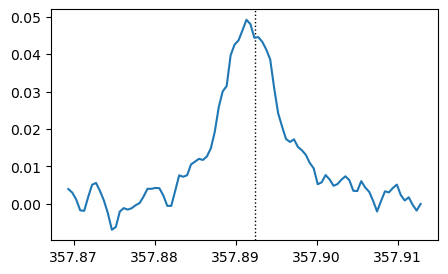

Lh07_SO2
0-39


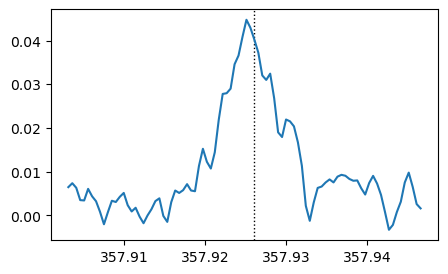

Lh07_SO2
0-40


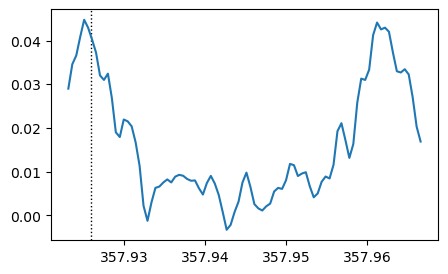

Lh07_SO2
0-41


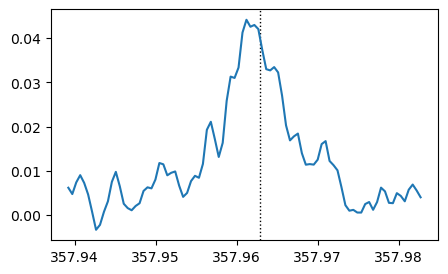

Lh07_SO2
0-42


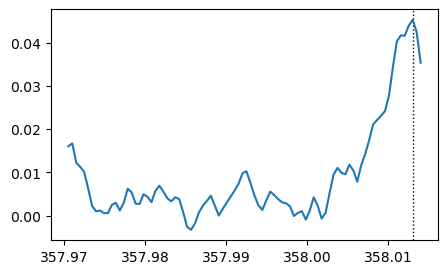

Lh07_SO2
0-43


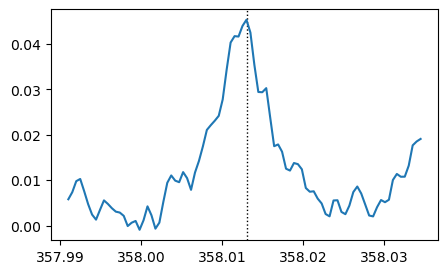

Lh07_SO2
0-44


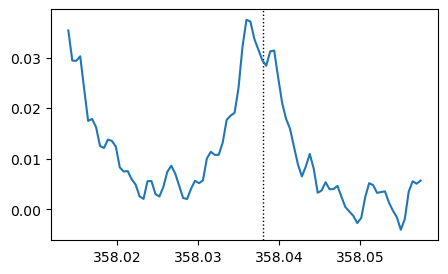

Lh07_SO2
0-45


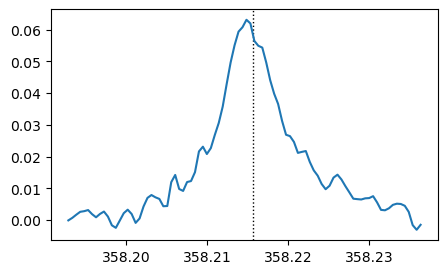

Lh07_SO2
0-46


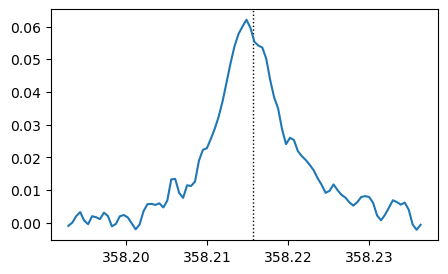

Lh07_CH3OH
0-47


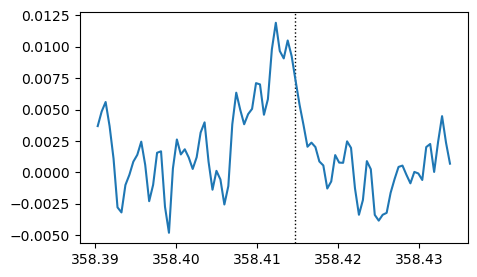

Lh07_CH3OCH3
0-48


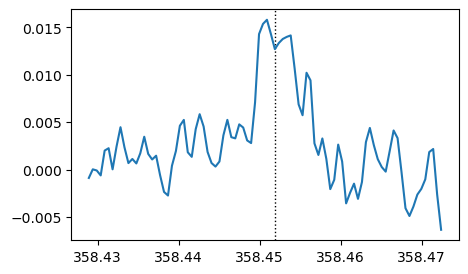

Lh07_CH3OH
0-49


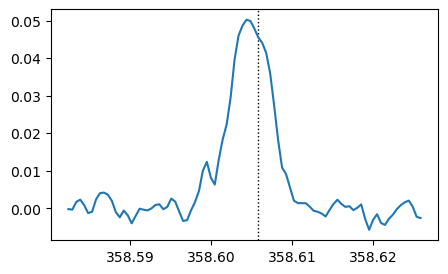

Lh07_34SO2
0-50


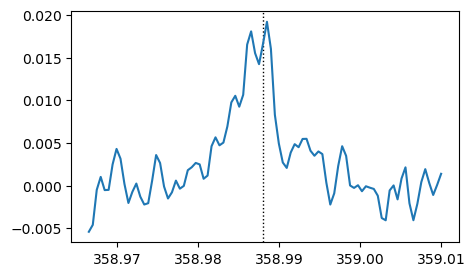

Lh07_SO2
0-51


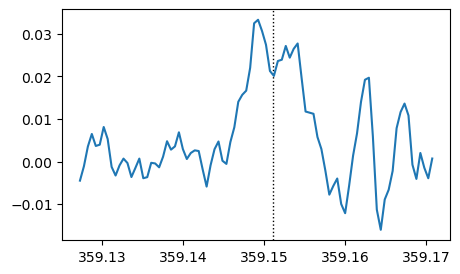

Lh07_SO2
0-52


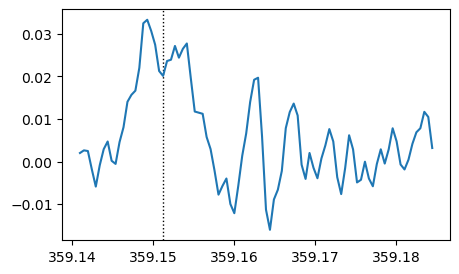

Lh07_SO2
0-54


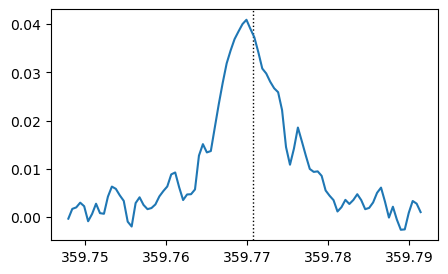

Lh09_SO
1-0


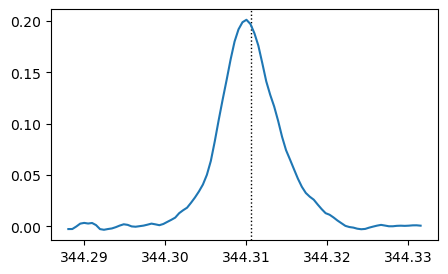

Lh09_34SO2
1-1


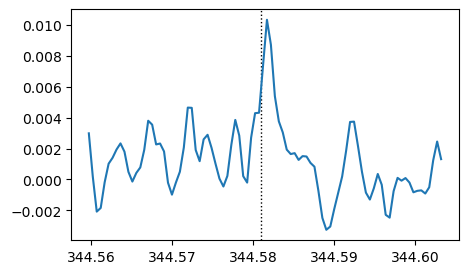

Lh09_SO2
1-2


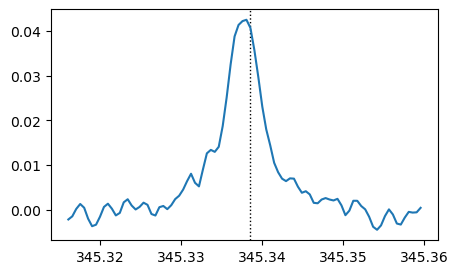

Lh09_CO
1-3


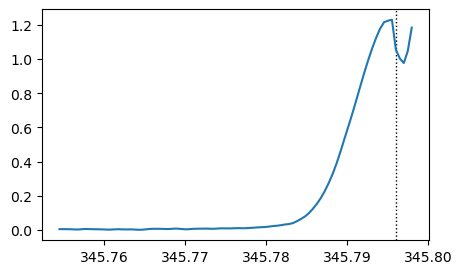

Lh09_CO
1-4


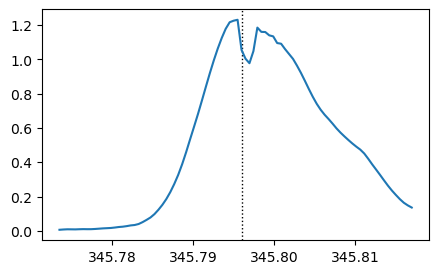

Lh09_SO
1-6


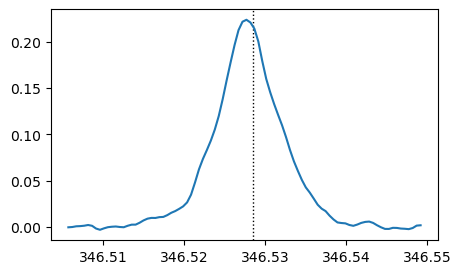

Lh09_SO2
1-7


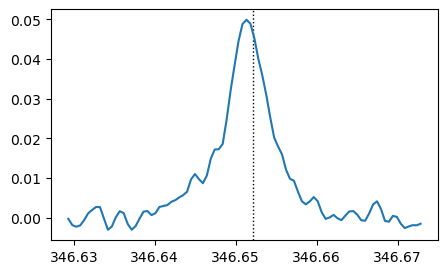

Lh09_H13CO+
1-10


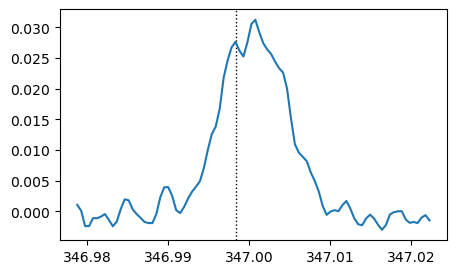

Lh09_SiO
1-11


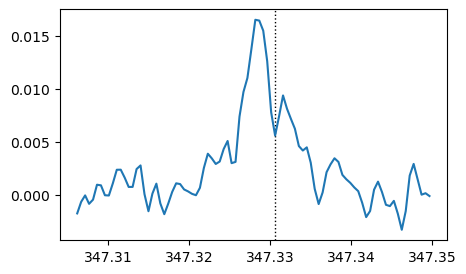

Lh09_SO+
1-12


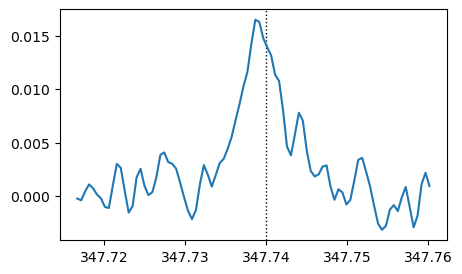

Lh09_H40delta
1-13


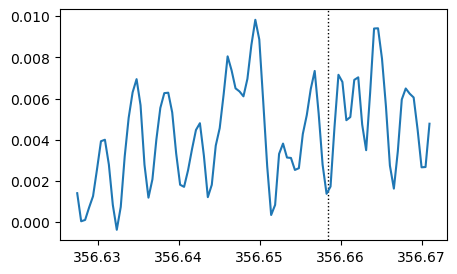

Lh09_H40delta
1-14


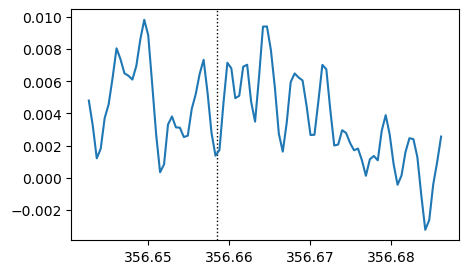

Lh09_HCO+
1-15


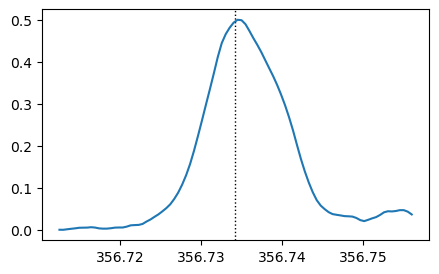

Lh09_HCO+
1-16


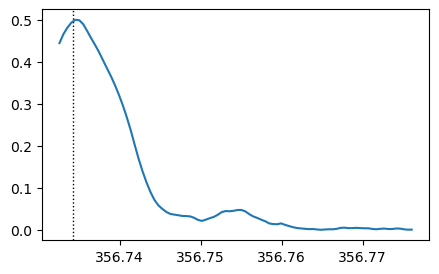

Lh09_SO2
1-17


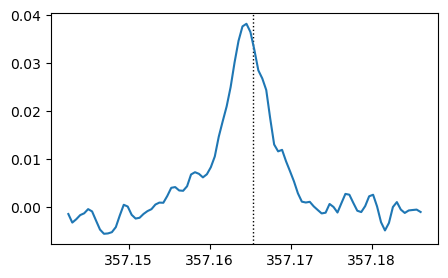

Lh09_SO2
1-18


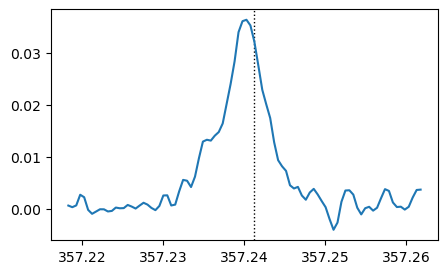

Lh09_SO2
1-19


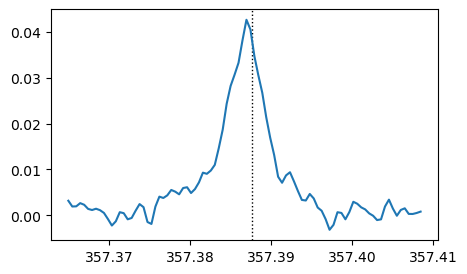

Lh09_SO2
1-20


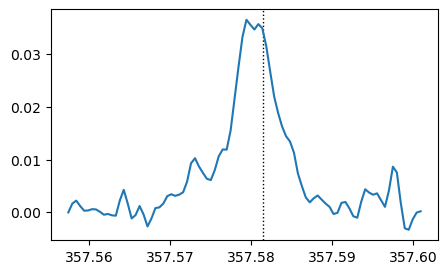

Lh09_SO2
1-21


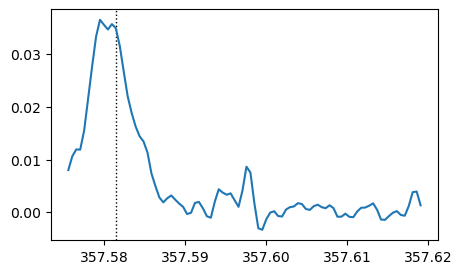

Lh09_SO2
1-22


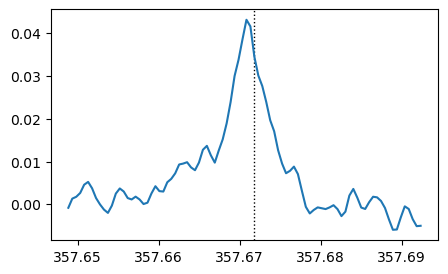

Lh09_SO2
1-23


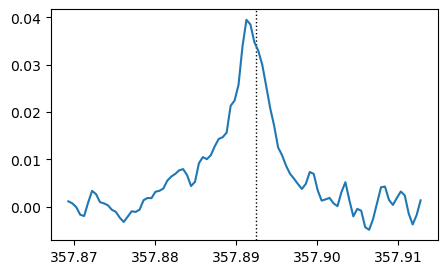

Lh09_SO2
1-24


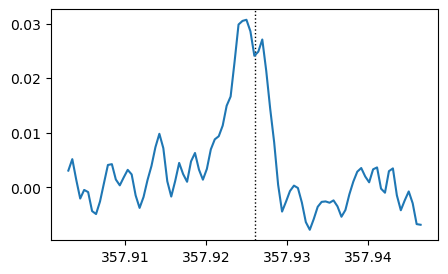

Lh09_SO2
1-25


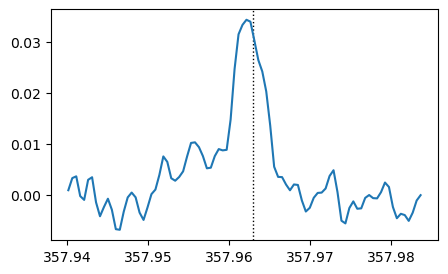

Lh09_SO2
1-26


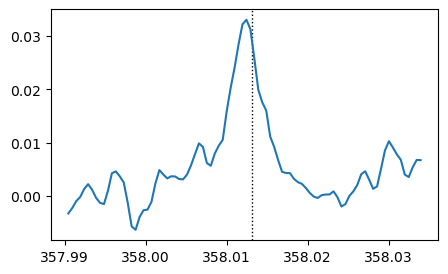

Lh09_SO2
1-27


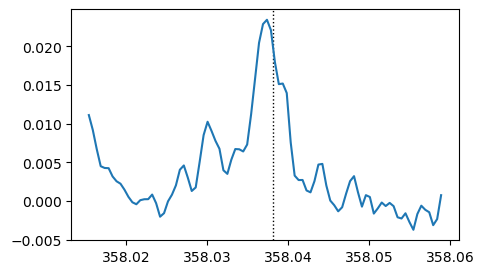

Lh09_SO2
1-28


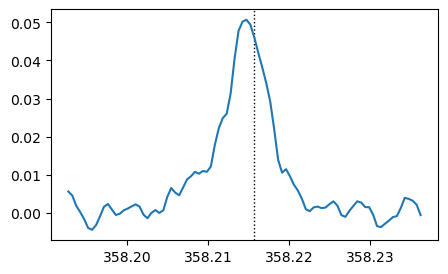

Lh09_SO2
1-29


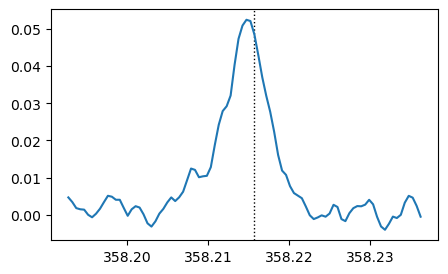

Lh09_SO2
1-30


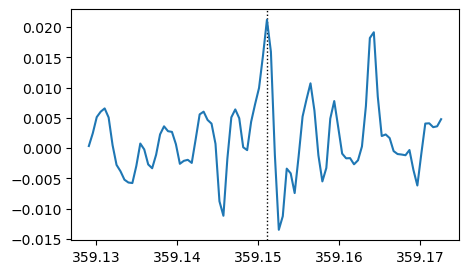

Lh09_SO2
1-31


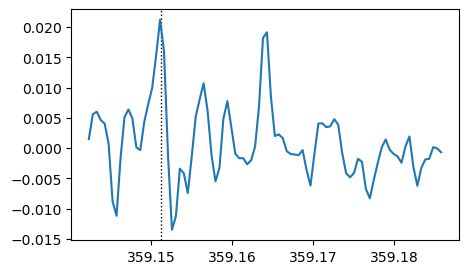

Lh09_SO2
1-32


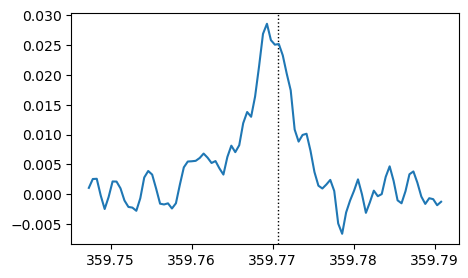

Lh10_34SO2
2-0


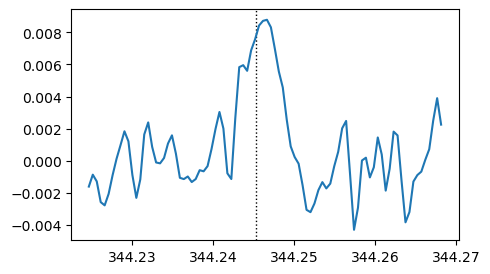

Lh10_SO
2-1


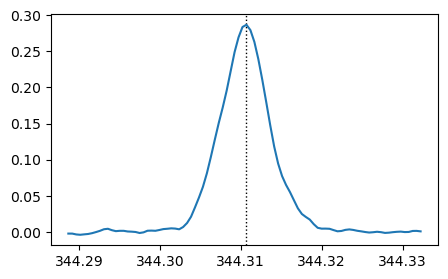

Lh10_34SO2
2-2


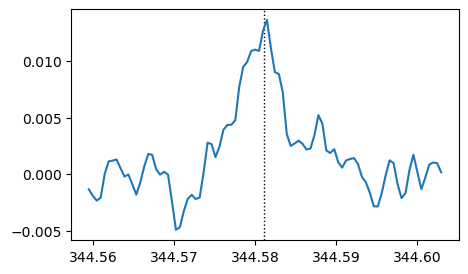

Lh10_34SO2
2-3


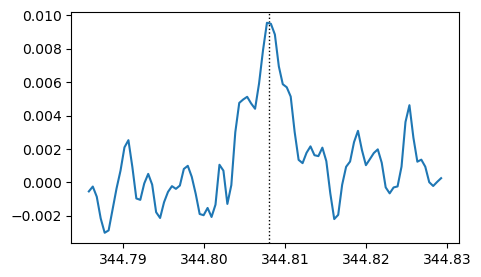

Lh10_34SO2
2-4


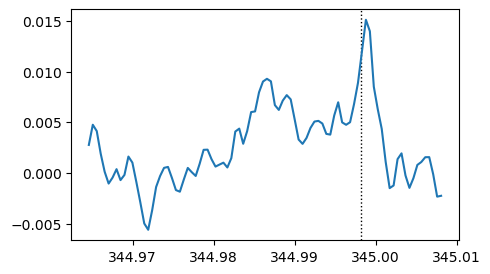

Lh10_34SO2
2-5


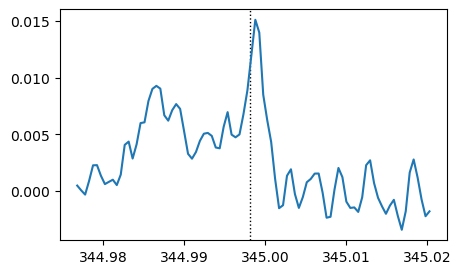

Lh10_34SO2
2-6


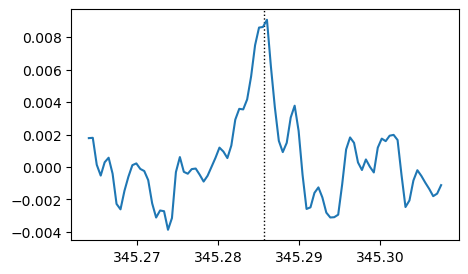

Lh10_SO2
2-7


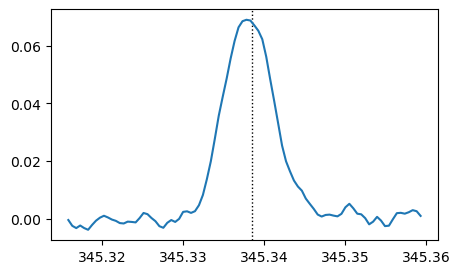

Lh10_34SO2
2-8


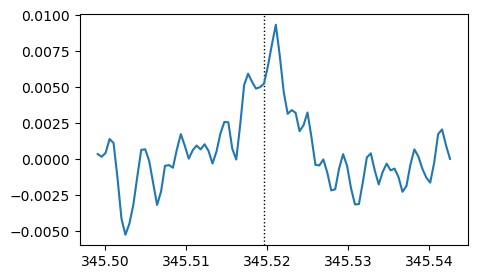

Lh10_34SO2
2-9


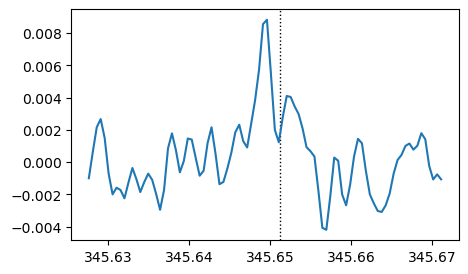

Lh10_CO
2-10


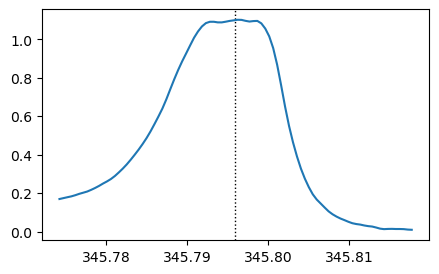

Lh10_CO
2-11


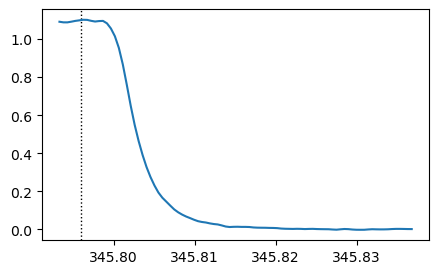

Lh10_SO
2-12


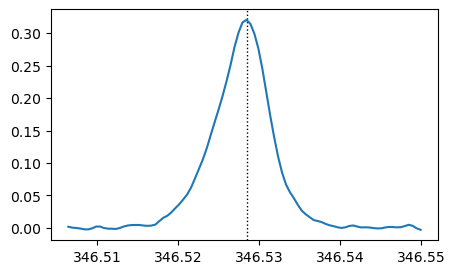

Lh10_SO2
2-13


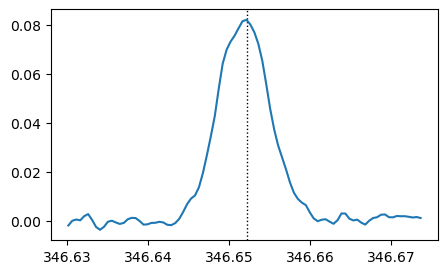

Lh10_H13CO+
2-14


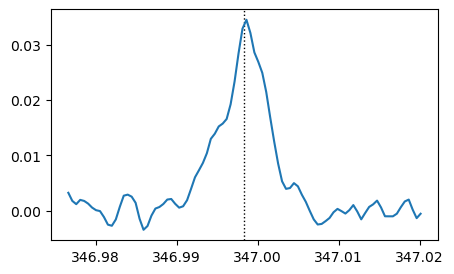

Lh10_SiO
2-15


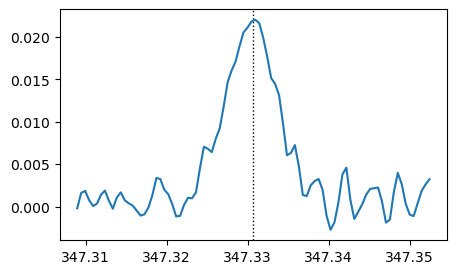

Lh10_SO+
2-16


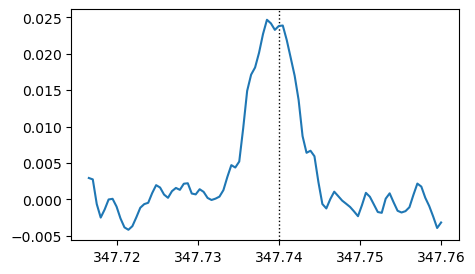

Lh10_HCO+
2-17


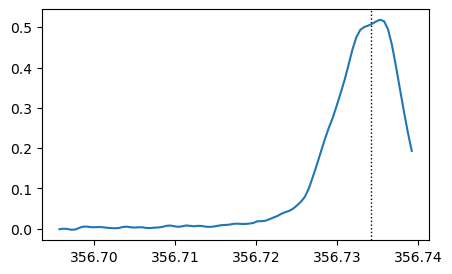

Lh10_HCO+
2-18


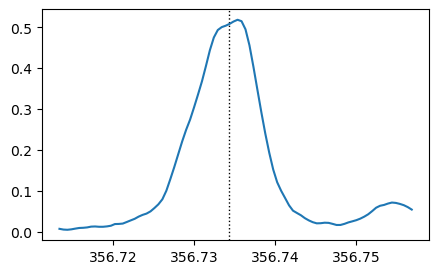

Lh10_HCO+
2-19


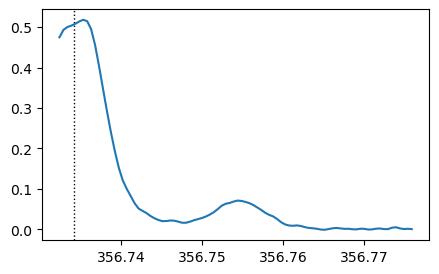

Lh10_34SO2
2-20


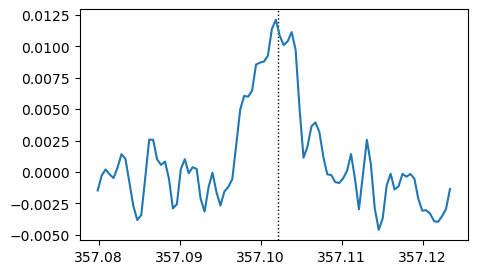

Lh10_SO2
2-21


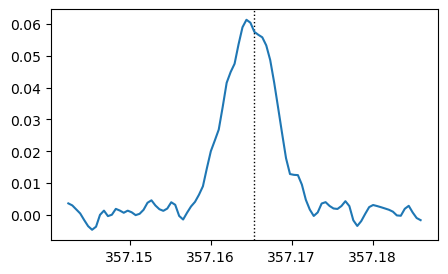

Lh10_SO2
2-22


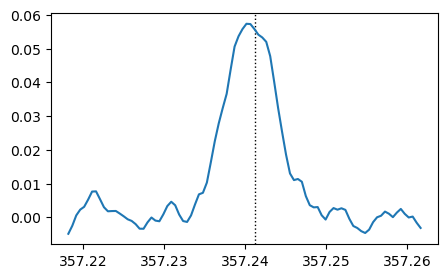

Lh10_SO2
2-23


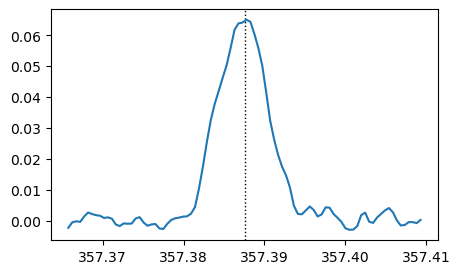

Lh10_SO2
2-24


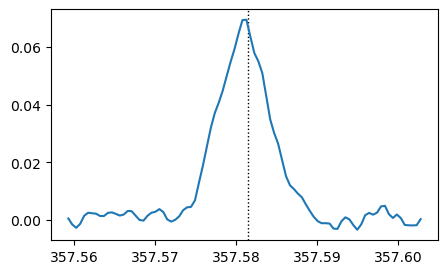

Lh10_SO2
2-25


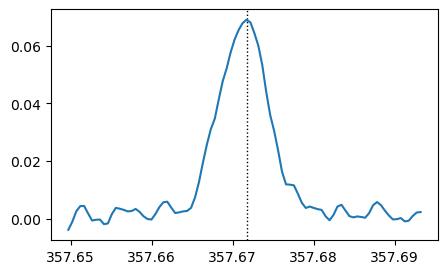

Lh10_SO2
2-26


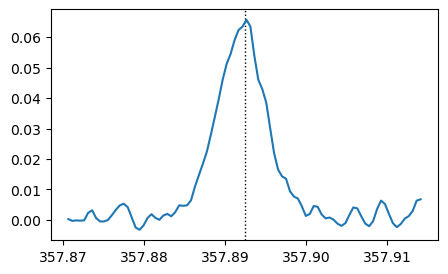

Lh10_SO2
2-27


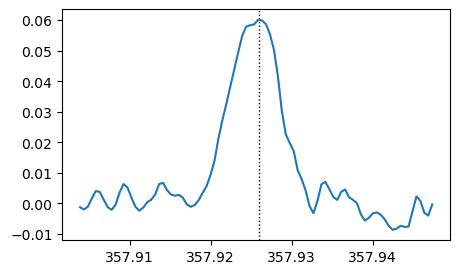

Lh10_SO2
2-28


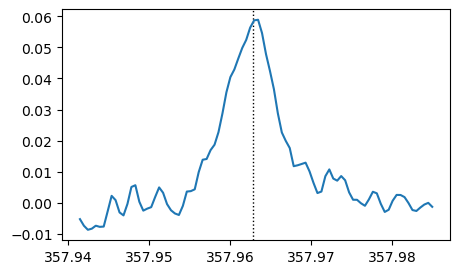

Lh10_SO2
2-29


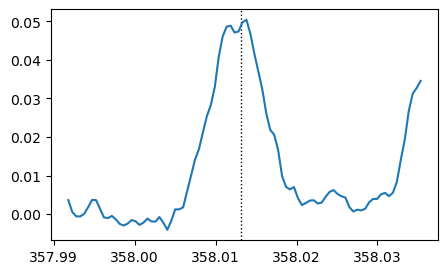

Lh10_SO2
2-30


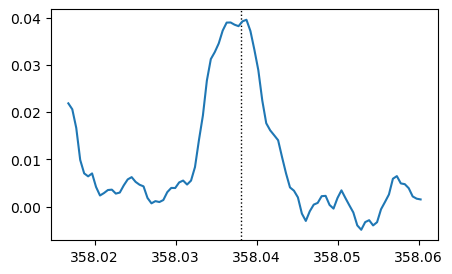

Lh10_SO2
2-31


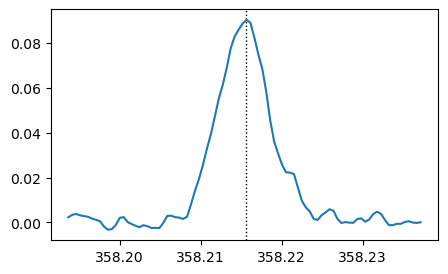

Lh10_SO2
2-32


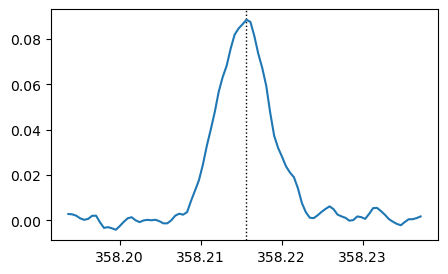

Lh10_34SO2
2-34


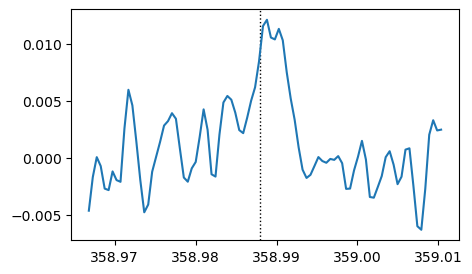

Lh10_SO2
2-35


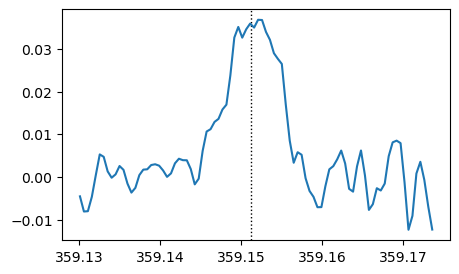

Lh10_SO2
2-36


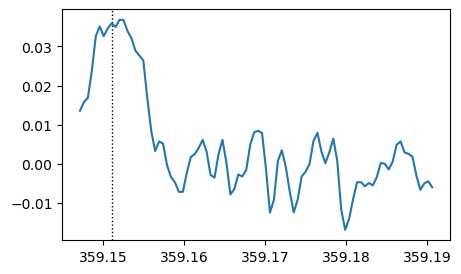

Lh10_SO2
2-39


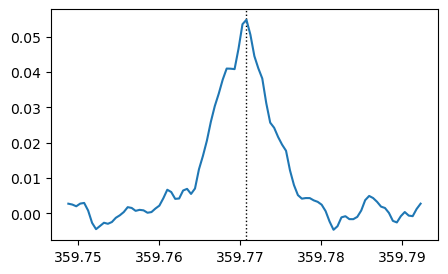

[[53], [5, 8, 9], [33, 37, 38, 40]]


In [8]:
# 画出单独的谱线，并找出每一根谱线的名字 （这个时候还不能把三个源的谱线合并到一起）
peak_name=[[] for i in range(3)]
peak_fre=[[] for i in range(3)]
shan=[[] for i in range(3)]

for n in range(len(x_large)):  # 循环三个源 第n个源
    for i in range(len(x_large[n])):  # 循环每个源中找到的谱线  第i条谱线
        puxian=[]
        for k in range(len(spectrum_fre)):   # 对某一根谱线
            peak_index=y_large[n][i].index(max(y_large[n][i]))  # 找到该区间的峰值
            puxian.append(abs(x_large[n][i][peak_index]-spectrum_fre[k]))  # 计算峰值的频率与所有谱线的频率的差，以谱线表为顺序

        if min(puxian)<0.01:  # 如果差值小于一定值
            puxian_index=puxian.index(min(puxian))   # 则认为差值最小的就是该谱线，记录这条谱线在谱线表中的位置为puxian_index
            print(target_name[n]+"_"+spectrum_name[puxian_index])    # 输出谱线名字
            print("{}-{}".format(n,i))  # 输出这是总谱线表中的第几个源的第几条谱线
            peak_name[n].append(target_name[n]+"_"+spectrum_name[puxian_index])  # 将这个谱线的名字记录在peak_name中
            peak_fre[n].append(spectrum_fre[puxian_index])   # 将这个谱线的静止频率记录在peak_fre中
            # 画图
            plt.figure(figsize=(5,3))
            plt.axvline(x=spectrum_fre[puxian_index], color="black", linestyle=":", linewidth=1)
            plt.plot(x_large[n][i],y_large[n][i])
            plt.ticklabel_format(useOffset=False, style='plain')
            plt.show()
        else:   # 如果差值都很大，认为这个点为误差点，不代表任何谱线，记录这个点的位置，待会删掉
            shan[n].append(i)
        
print(shan)

In [9]:
# 删掉找不到的谱线
for n in range(len(shan)):
    for i in range(len(shan[n])-1,-1,-1):
    #     print(i)
        del x_large[n][shan[n][i]]
        del y_large[n][shan[n][i]]

In [10]:
# 删除峰值偏离中心的谱线
shan2=[[] for i in range(3)]
for n in range(len(y_large)):
    for i in range(len(y_large[n])):
        max_index=y_large[n][i].index(max(y_large[n][i]))
        if max_index>75 or max_index<25:
            shan2[n].append(i)
            
for n in range(len(shan2)):
    for i in range(len(shan2[n])-1,-1,-1):
    #     print(i)
        del x_large[n][shan2[n][i]]
        del y_large[n][shan2[n][i]]
        del peak_fre[n][shan2[n][i]]
        del peak_name[n][shan2[n][i]]

Lh07_HC15N
0-0


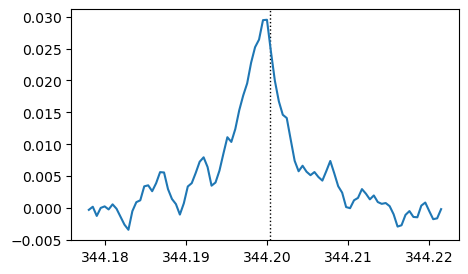

Lh07_34SO2
0-1


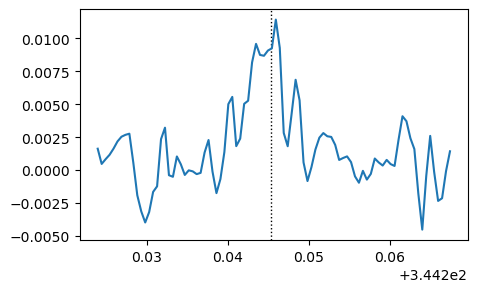

Lh07_SO
0-2


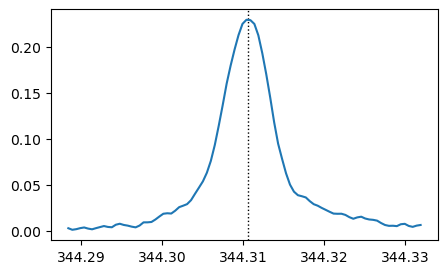

Lh07_CH3OH
0-3


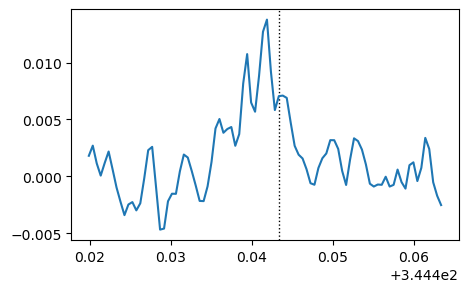

Lh07_34SO2
0-4


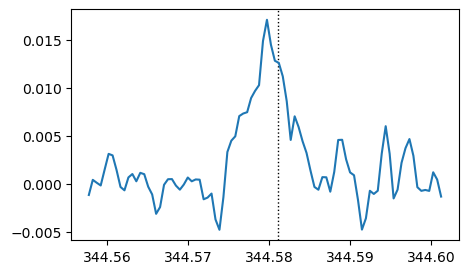

Lh07_34SO2
0-5


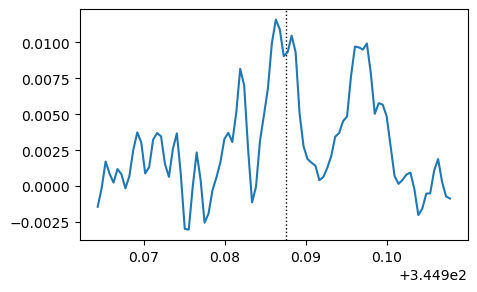

Lh07_t-HCOOH
0-6


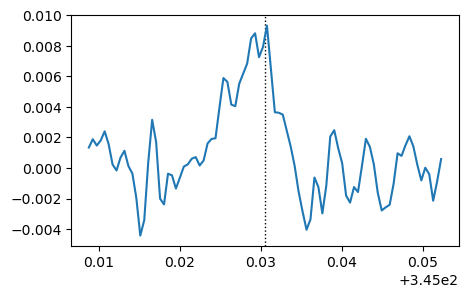

Lh07_34SO2
0-7


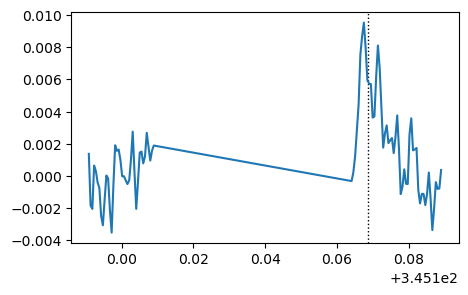

Lh07_SO2
0-8


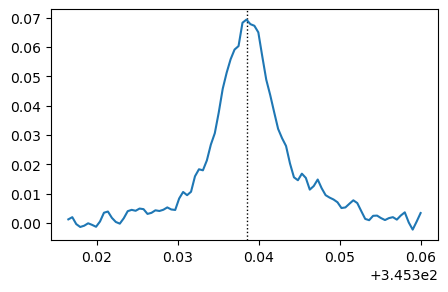

Lh07_34SO2
0-9


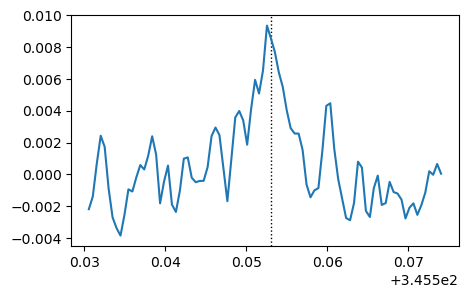

Lh07_HC3N
0-10


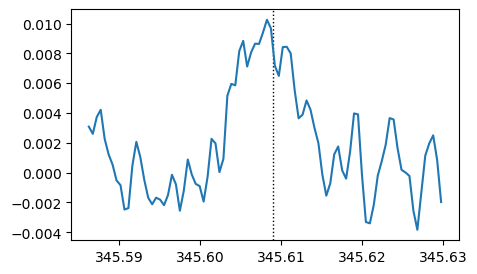

Lh07_CO
0-11


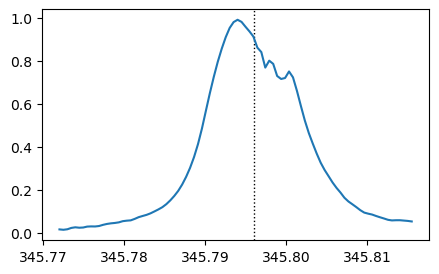

Lh07_CH3OH
0-12


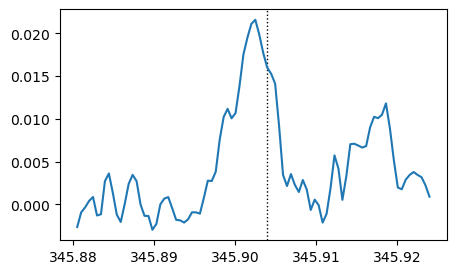

Lh07_CH3OH
0-13


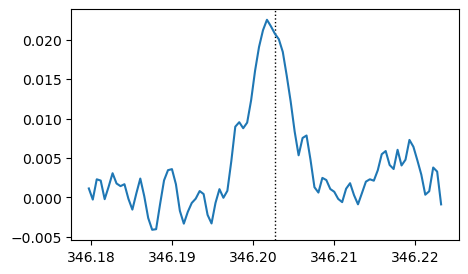

Lh07_SO
0-14


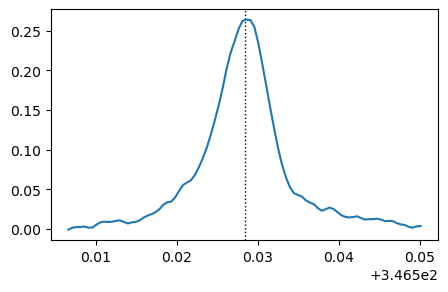

Lh07_SO2
0-15


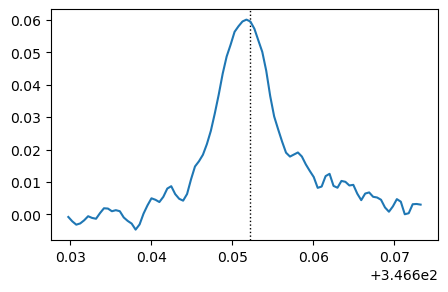

Lh07_t-HCOOH
0-16


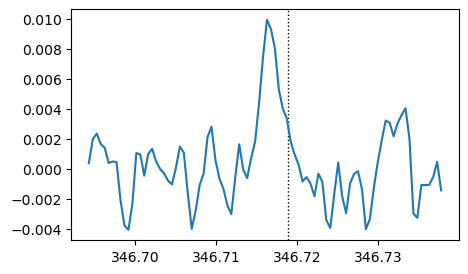

Lh07_H13CO+
0-17


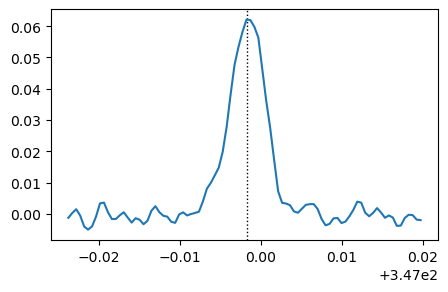

Lh07_SiO
0-18


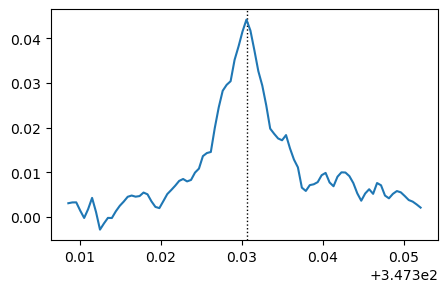

Lh07_HCO+
0-19


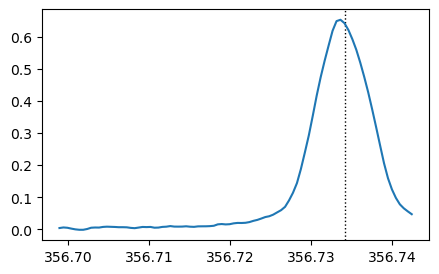

Lh07_HCO+
0-20


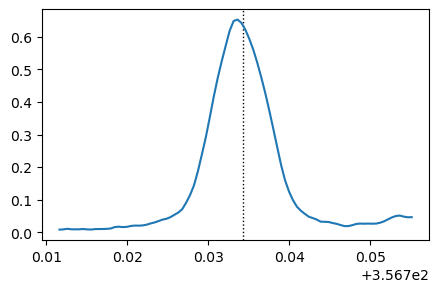

Lh07_34SO2
0-21


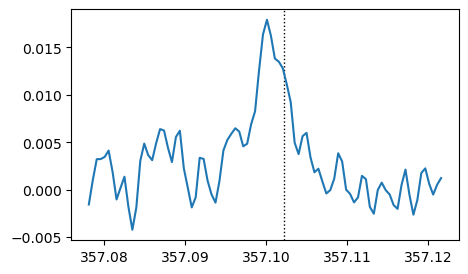

Lh07_SO2
0-22


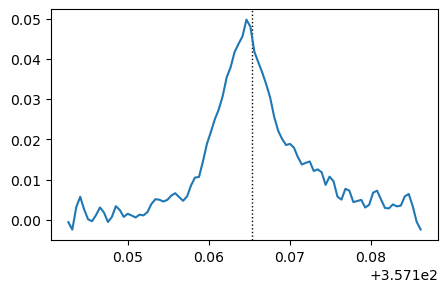

Lh07_SO2
0-23


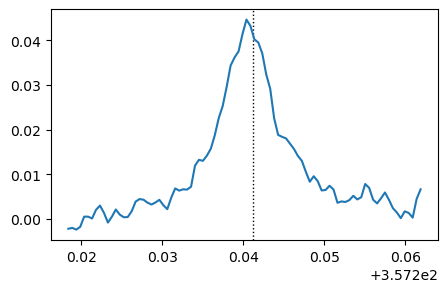

Lh07_SO2
0-24


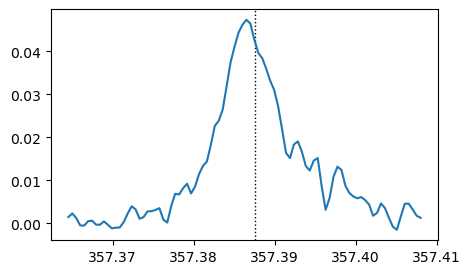

Lh07_CH3OCH3
0-25


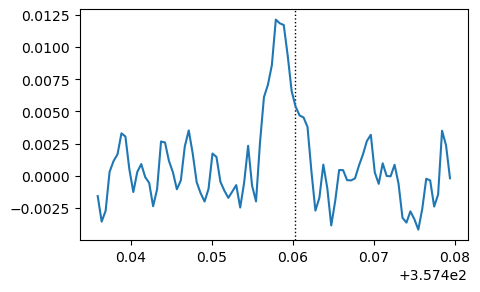

Lh07_SO2
0-26


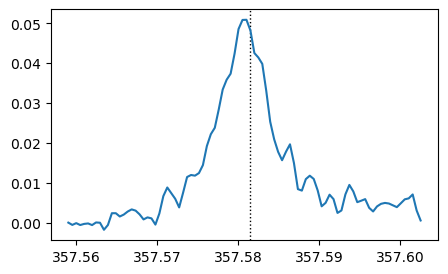

Lh07_SO2
0-27


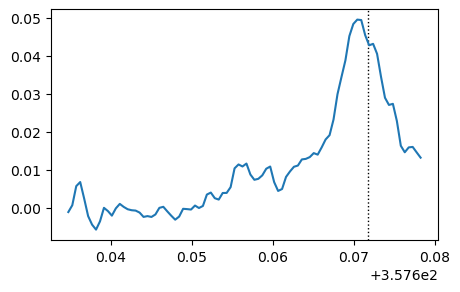

Lh07_SO2
0-28


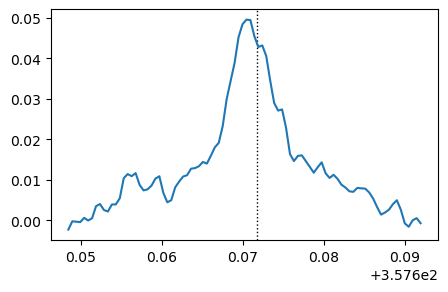

Lh07_SO2
0-29


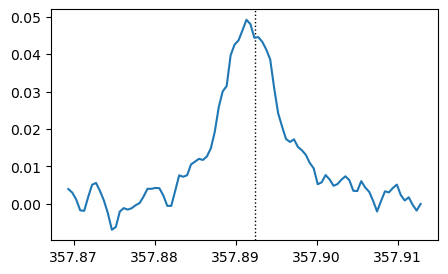

Lh07_SO2
0-30


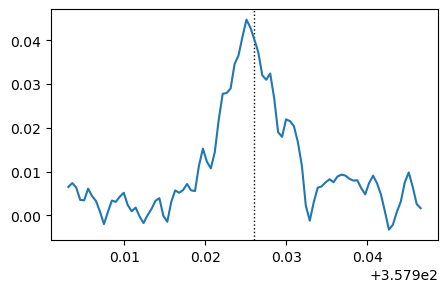

Lh07_SO2
0-31


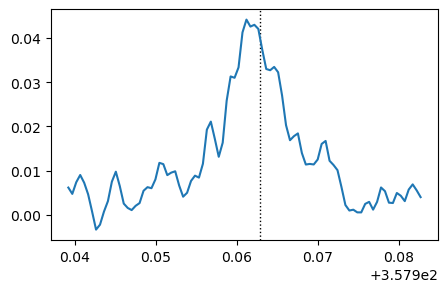

Lh07_SO2
0-32


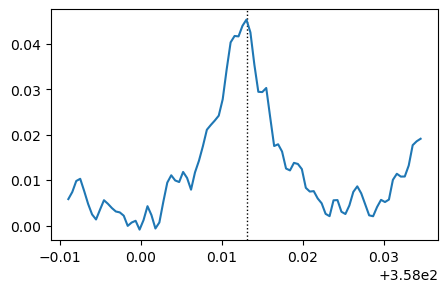

Lh07_SO2
0-33


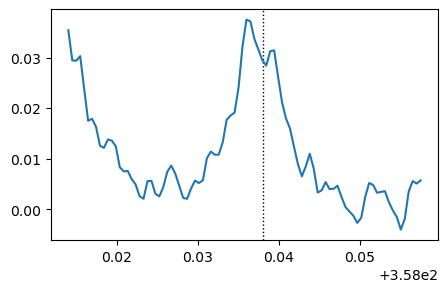

Lh07_SO2
0-34


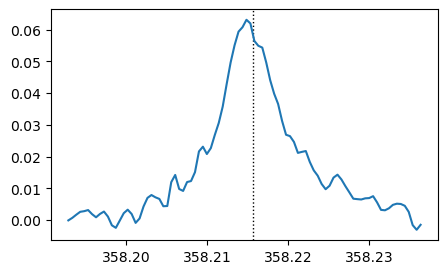

Lh07_SO2
0-35


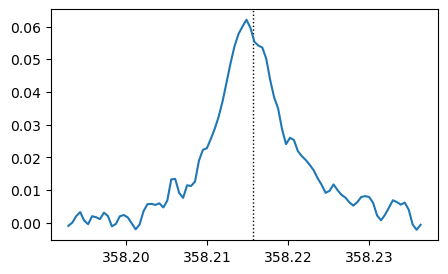

Lh07_CH3OH
0-36


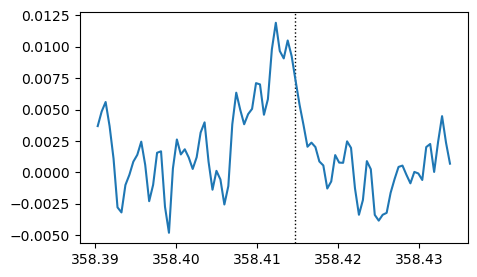

Lh07_CH3OCH3
0-37


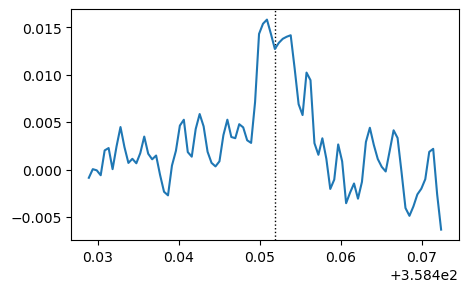

Lh07_CH3OH
0-38


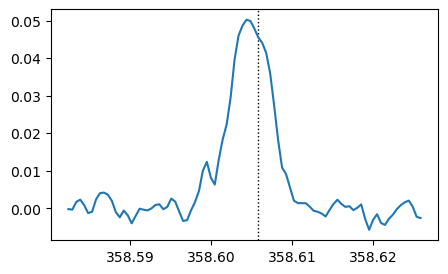

Lh07_34SO2
0-39


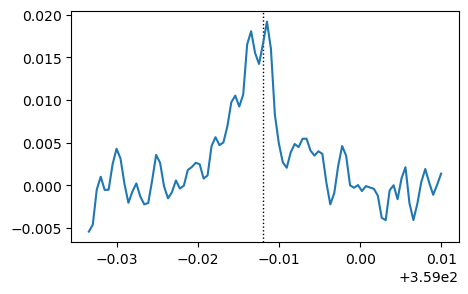

Lh07_SO2
0-40


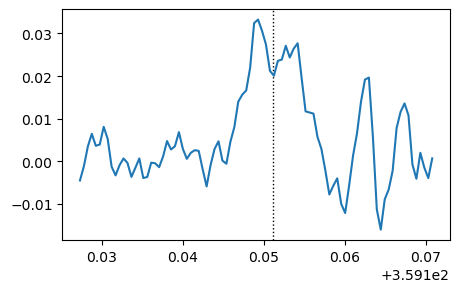

Lh07_SO2
0-41


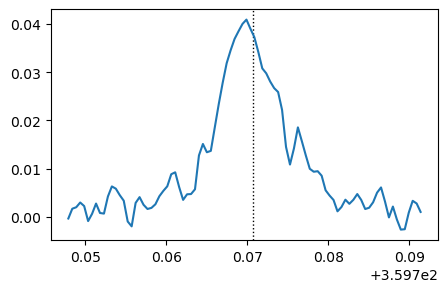

Lh09_SO
1-0


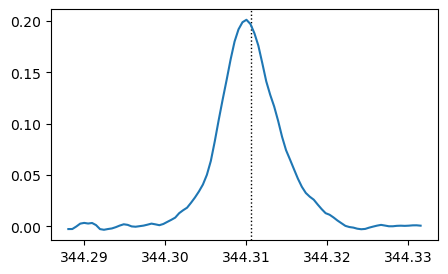

Lh09_34SO2
1-1


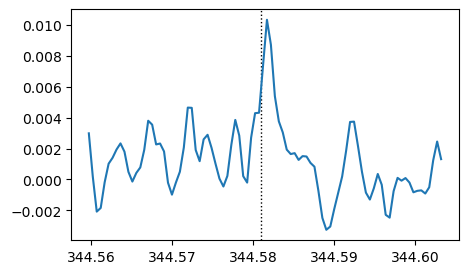

Lh09_SO2
1-2


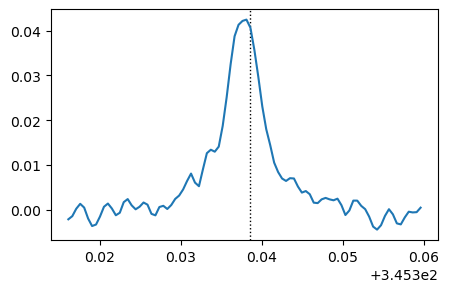

Lh09_CO
1-3


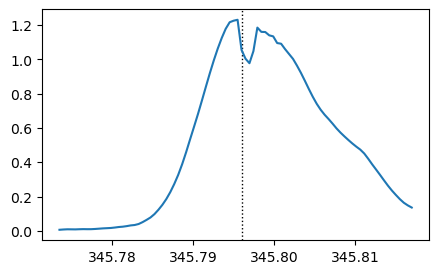

Lh09_SO
1-4


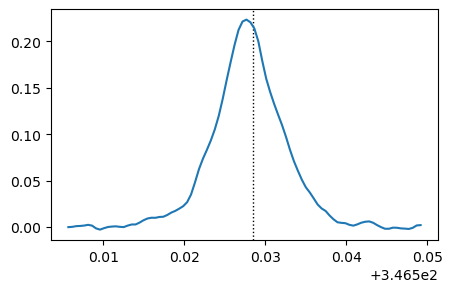

Lh09_SO2
1-5


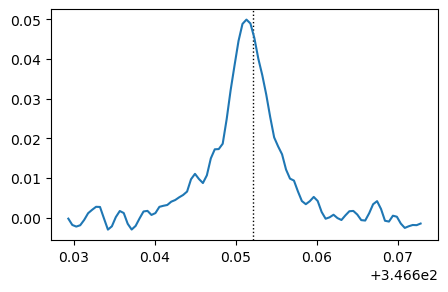

Lh09_H13CO+
1-6


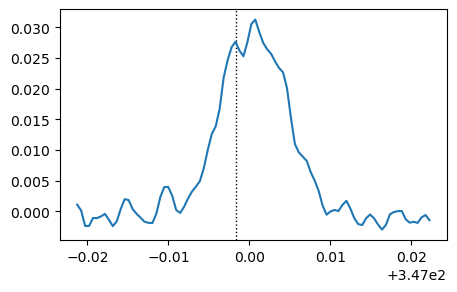

Lh09_SiO
1-7


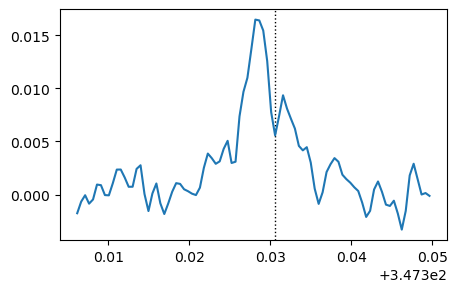

Lh09_SO+
1-8


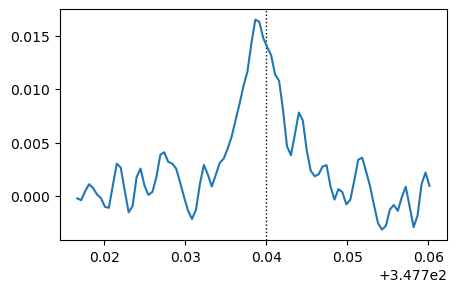

Lh09_H40delta
1-9


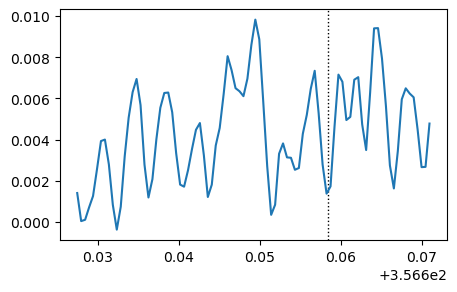

Lh09_HCO+
1-10


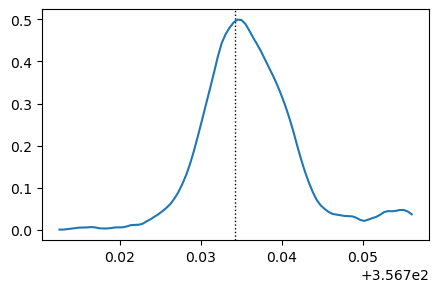

Lh09_SO2
1-11


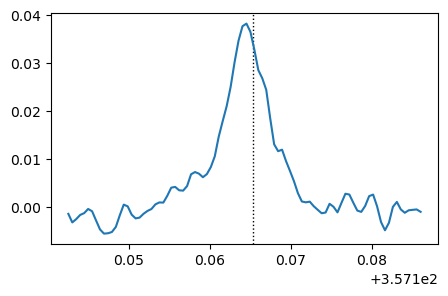

Lh09_SO2
1-12


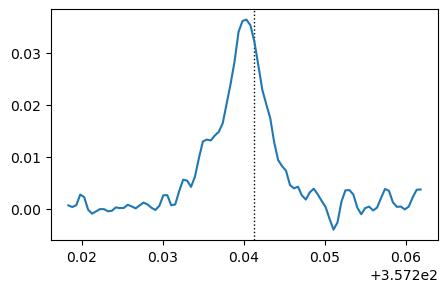

Lh09_SO2
1-13


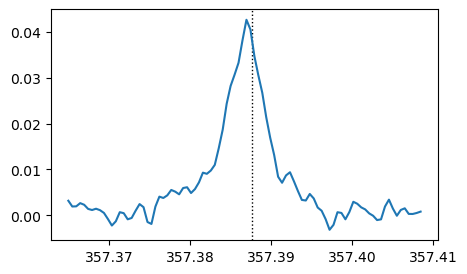

Lh09_SO2
1-14


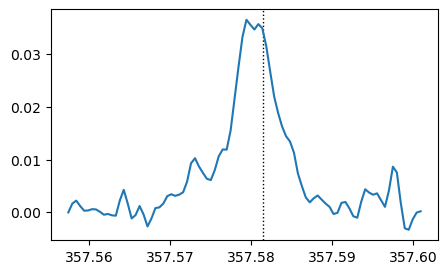

Lh09_SO2
1-15


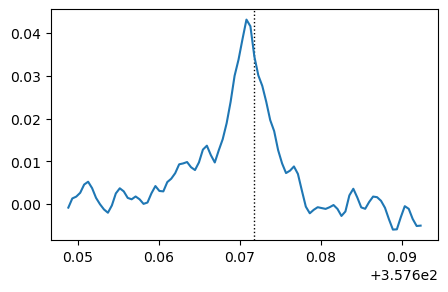

Lh09_SO2
1-16


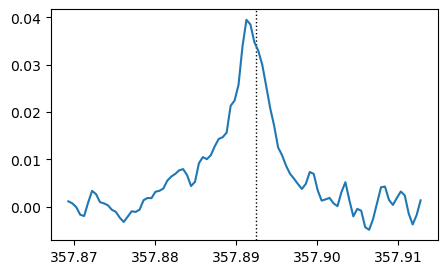

Lh09_SO2
1-17


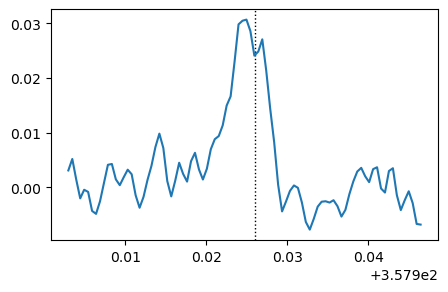

Lh09_SO2
1-18


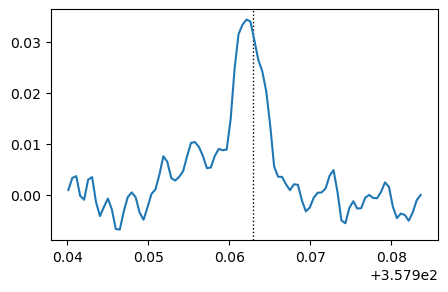

Lh09_SO2
1-19


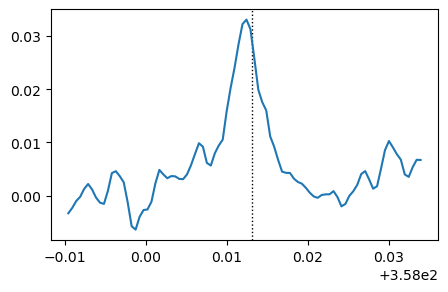

Lh09_SO2
1-20


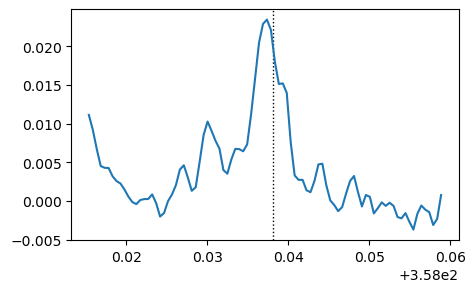

Lh09_SO2
1-21


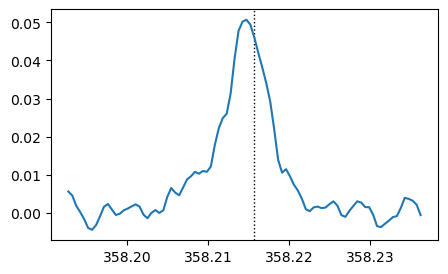

Lh09_SO2
1-22


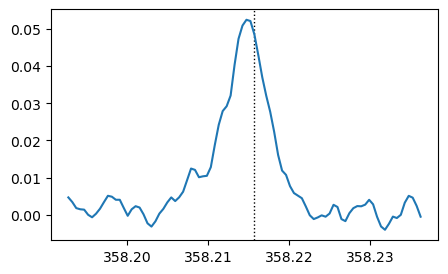

Lh09_SO2
1-23


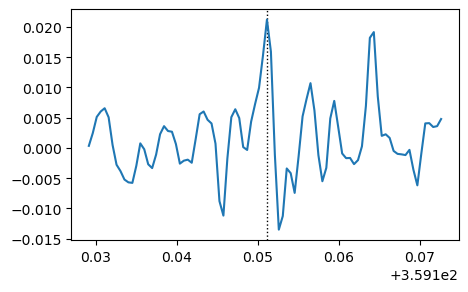

Lh09_SO2
1-24


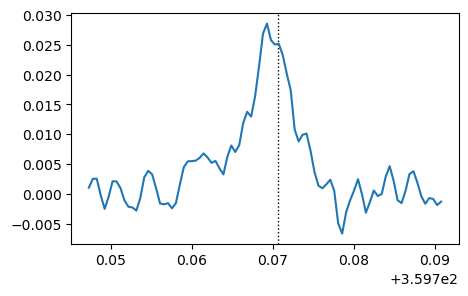

Lh10_34SO2
2-0


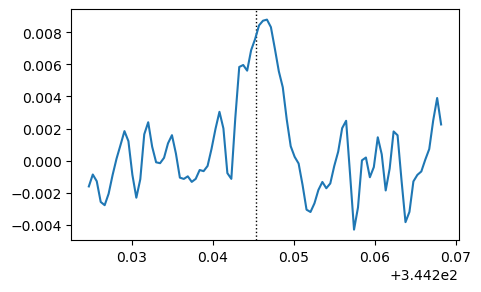

Lh10_SO
2-1


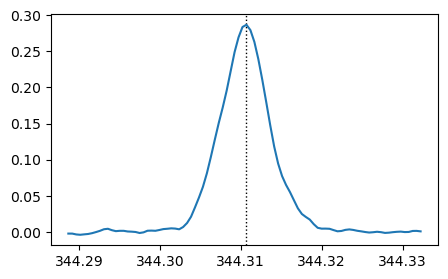

Lh10_34SO2
2-2


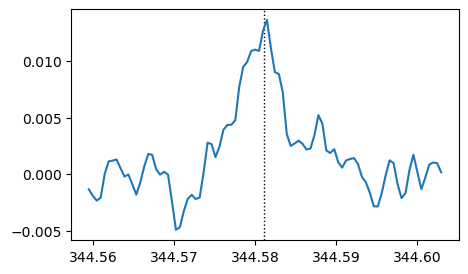

Lh10_34SO2
2-3


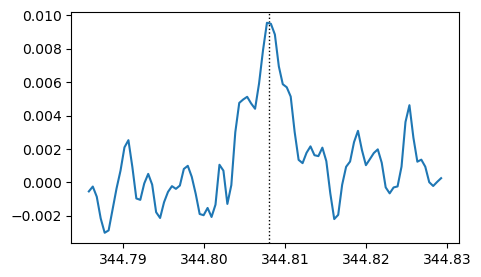

Lh10_34SO2
2-4


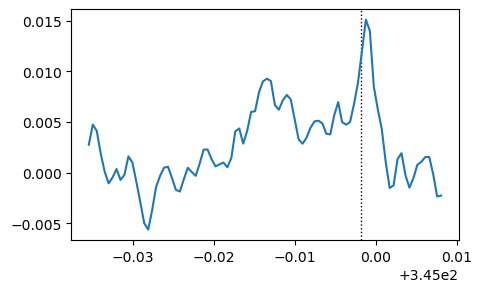

Lh10_34SO2
2-5


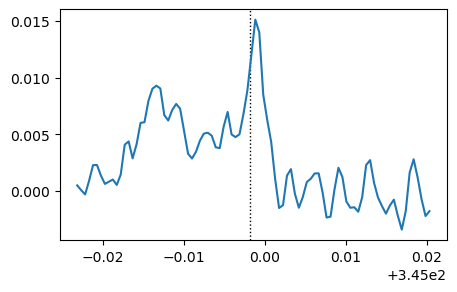

Lh10_34SO2
2-6


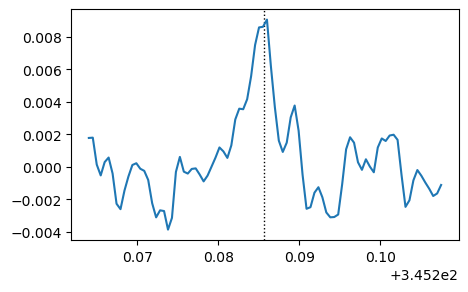

Lh10_SO2
2-7


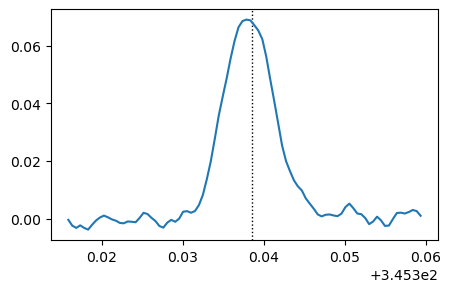

Lh10_34SO2
2-8


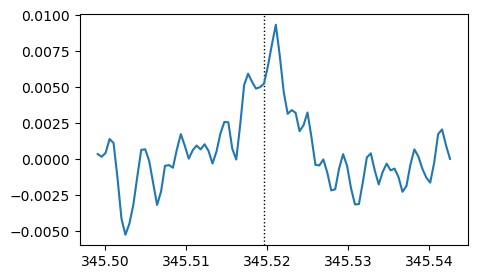

Lh10_34SO2
2-9


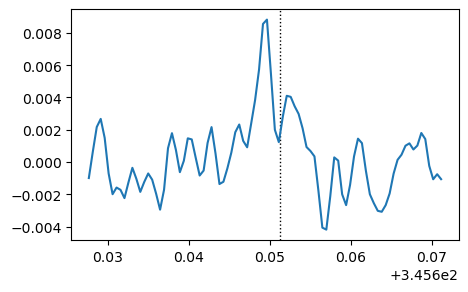

Lh10_CO
2-10


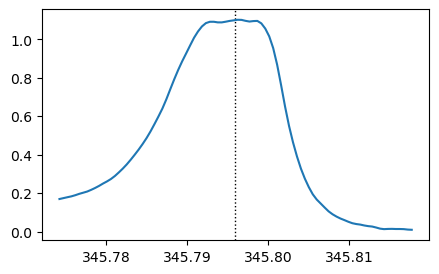

Lh10_SO
2-11


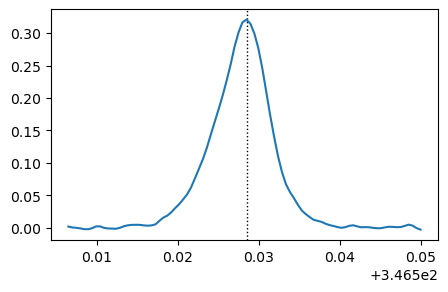

Lh10_SO2
2-12


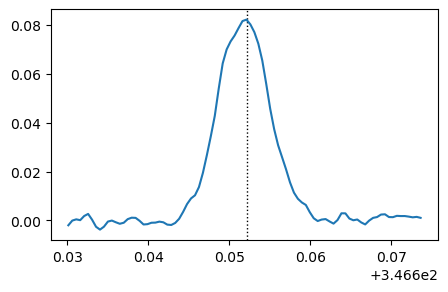

Lh10_H13CO+
2-13


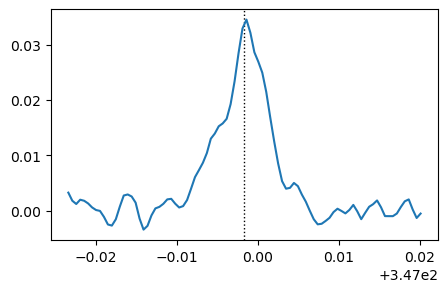

Lh10_SiO
2-14


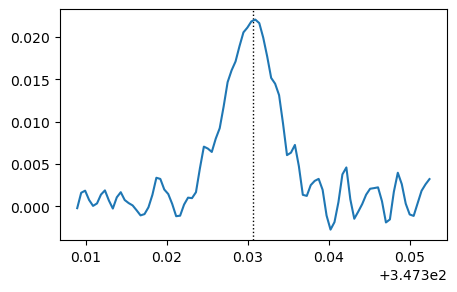

Lh10_SO+
2-15


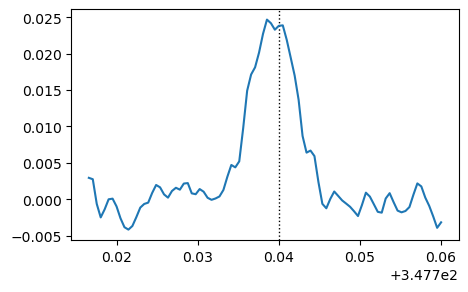

Lh10_HCO+
2-16


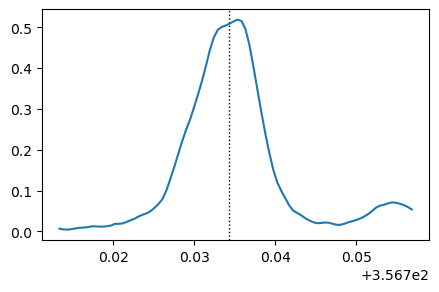

Lh10_34SO2
2-17


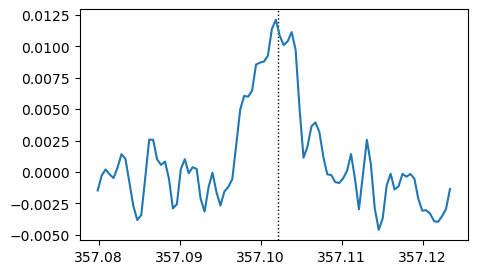

Lh10_SO2
2-18


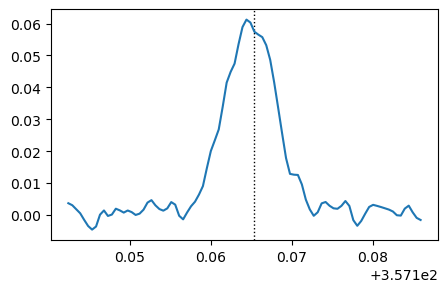

Lh10_SO2
2-19


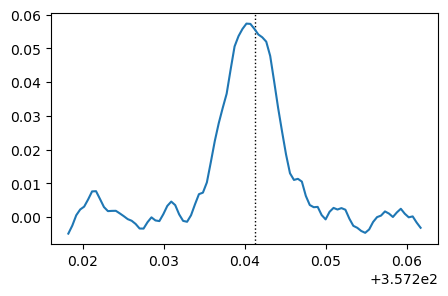

Lh10_SO2
2-20


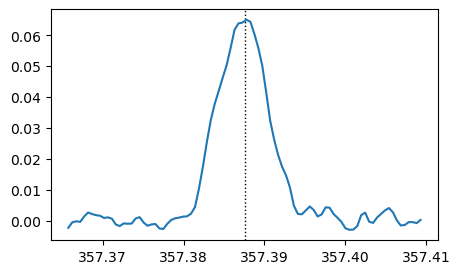

Lh10_SO2
2-21


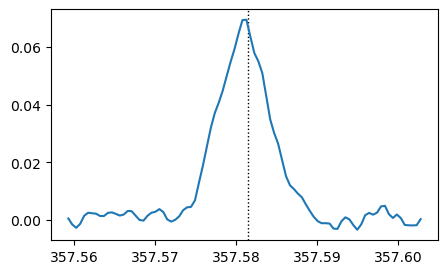

Lh10_SO2
2-22


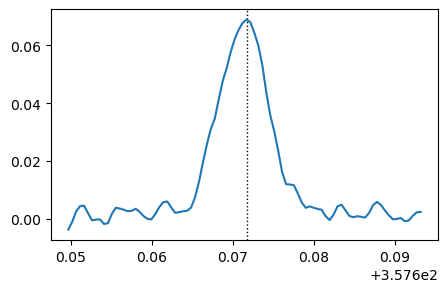

Lh10_SO2
2-23


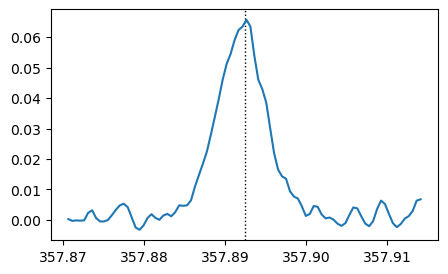

Lh10_SO2
2-24


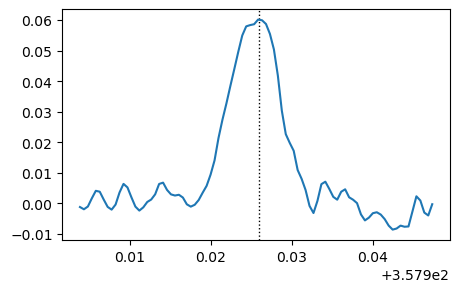

Lh10_SO2
2-25


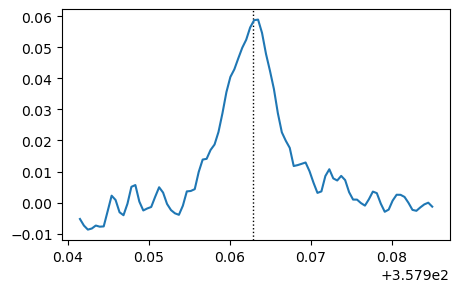

Lh10_SO2
2-26


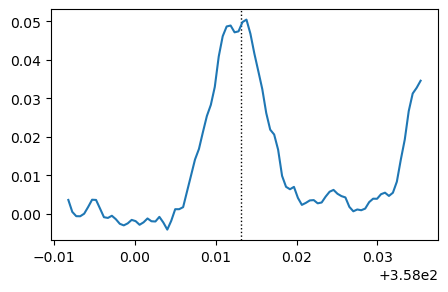

Lh10_SO2
2-27


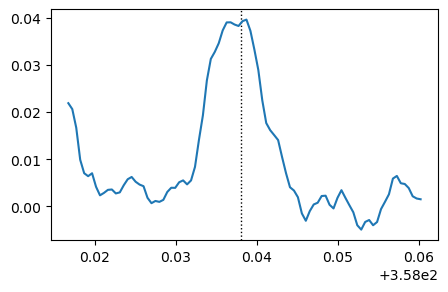

Lh10_SO2
2-28


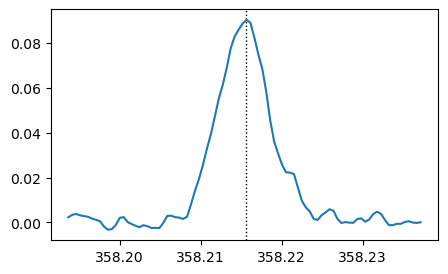

Lh10_SO2
2-29


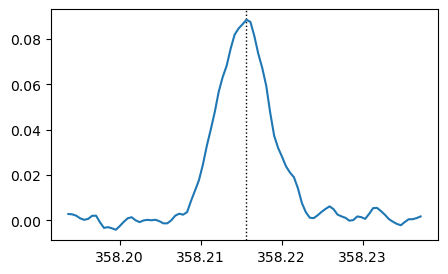

Lh10_34SO2
2-30


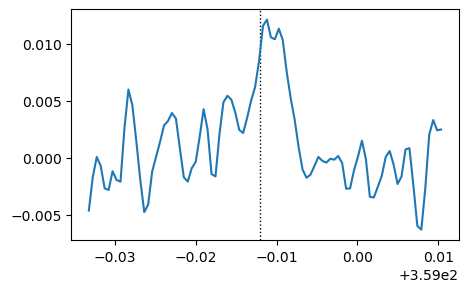

Lh10_SO2
2-31


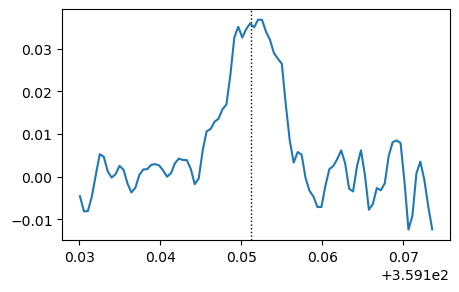

Lh10_SO2
2-32


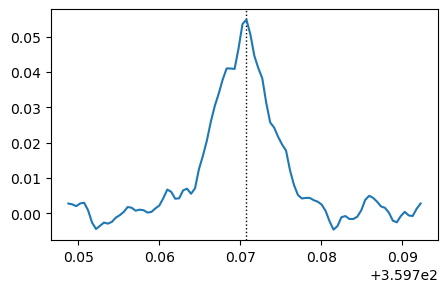

In [11]:
# 人工复检
for n in range(len(x_large)):
    for i in range(len(x_large[n])):
        print(peak_name[n][i])
        print("{}-{}".format(n,i))
        plt.figure(figsize=(5,3))
        plt.axvline(x=peak_fre[n][i], color="black", linestyle=":", linewidth=1)
        plt.plot(x_large[n][i],y_large[n][i])
        plt.show()

In [12]:
# 人工删除
shan2=[[7,19,27],[9],[4]]   # 手动输入需要删掉的谱线
for n in range(len(shan2)):
    for i in range(len(shan2[n])-1,-1,-1):
        del x_large[n][shan2[n][i]]
        del y_large[n][shan2[n][i]]
        del peak_fre[n][shan2[n][i]]
        del peak_name[n][shan2[n][i]]
        
for n in range(len(x_large)):
    print(len(x_large[n]))

39
24
32


In [15]:
print(peak_fre)
print(len(peak_fre[0]))

[[344.2003199, 344.2453476, 344.310612, 344.443433, 344.581045, 344.9875851, 345.030561, 345.3385391, 345.5530949, 345.60901, 345.7959899, 345.903916, 346.202719, 346.528481, 346.6521672, 346.718858, 346.998344, 347.330631, 356.734223, 357.1021822, 357.16536, 357.24119, 357.38757, 357.4602017, 357.5814483, 357.67178, 357.892442, 357.92596, 357.96289, 358.01309, 358.03808, 358.21564, 358.21564, 358.414648, 358.4519426, 358.605799, 358.9879745, 359.151156, 359.7706815], [344.310612, 344.581045, 345.3385391, 345.7959899, 346.528481, 346.6521672, 346.998344, 347.330631, 347.740011, 356.734223, 357.16536, 357.24119, 357.38757, 357.5814483, 357.67178, 357.892442, 357.92596, 357.96289, 358.01309, 358.03808, 358.21564, 358.21564, 359.151156, 359.7706815], [344.2453476, 344.310612, 344.581045, 344.8079157, 344.9981616, 345.2856217, 345.3385391, 345.5196584, 345.6512957, 345.7959899, 346.528481, 346.6521672, 346.998344, 347.330631, 347.740011, 356.734223, 357.1021822, 357.16536, 357.24119, 357.3

In [17]:
flat_list_fre = [item for sublist in x_large for item in sublist]
flat_list_flux = [item for sublist in y_large for item in sublist]
flat_list_name = [item for sublist in peak_name for item in sublist]

print(len(flat_list_flux))
print(flat_list_name)

95
['Lh07_HC15N', 'Lh07_34SO2', 'Lh07_SO', 'Lh07_CH3OH', 'Lh07_34SO2', 'Lh07_34SO2', 'Lh07_t-HCOOH', 'Lh07_SO2', 'Lh07_34SO2', 'Lh07_HC3N', 'Lh07_CO', 'Lh07_CH3OH', 'Lh07_CH3OH', 'Lh07_SO', 'Lh07_SO2', 'Lh07_t-HCOOH', 'Lh07_H13CO+', 'Lh07_SiO', 'Lh07_HCO+', 'Lh07_34SO2', 'Lh07_SO2', 'Lh07_SO2', 'Lh07_SO2', 'Lh07_CH3OCH3', 'Lh07_SO2', 'Lh07_SO2', 'Lh07_SO2', 'Lh07_SO2', 'Lh07_SO2', 'Lh07_SO2', 'Lh07_SO2', 'Lh07_SO2', 'Lh07_SO2', 'Lh07_CH3OH', 'Lh07_CH3OCH3', 'Lh07_CH3OH', 'Lh07_34SO2', 'Lh07_SO2', 'Lh07_SO2', 'Lh09_SO', 'Lh09_34SO2', 'Lh09_SO2', 'Lh09_CO', 'Lh09_SO', 'Lh09_SO2', 'Lh09_H13CO+', 'Lh09_SiO', 'Lh09_SO+', 'Lh09_HCO+', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh09_SO2', 'Lh10_34SO2', 'Lh10_SO', 'Lh10_34SO2', 'Lh10_34SO2', 'Lh10_34SO2', 'Lh10_34SO2', 'Lh10_SO2', 'Lh10_34SO2', 'Lh10_34SO2', 'Lh10_CO', 'Lh10_SO', 'Lh10_SO2', 'Lh10_H13CO+', 'Lh10_SiO', 'Lh10_SO+', '

In [18]:
class create_data_Results:
    def __init__(self):
        self.fre = flat_list_fre
        self.flux = flat_list_flux
        self.name = flat_list_name

In [19]:
old_data = create_data_Results()

In [24]:
marked_list1=[[] for i in range(len(peak_fre))]

for n in range(len(peak_fre)):
    # 标记存在谱线的频率
    peak_fre_Lh=peak_fre[n]
    print(peak_fre_Lh)

    # 将list1转换为集合
    set1 = set(peak_fre_Lh)

    # 标记第二个列表
    marked_Lh = [(x, x in set1) for x in spectrum_fre]
    for i in range(len(marked_Lh)):
        if marked_Lh[i][1]==True:
            marked_list1[n].append(1)
        else:
            marked_list1[n].append(0)
        
print(marked_list1)
print(len(marked_list1))


[344.2003199, 344.2453476, 344.310612, 344.443433, 344.581045, 344.9875851, 345.030561, 345.3385391, 345.5530949, 345.60901, 345.7959899, 345.903916, 346.202719, 346.528481, 346.6521672, 346.718858, 346.998344, 347.330631, 356.734223, 357.1021822, 357.16536, 357.24119, 357.38757, 357.4602017, 357.5814483, 357.67178, 357.892442, 357.92596, 357.96289, 358.01309, 358.03808, 358.21564, 358.21564, 358.414648, 358.4519426, 358.605799, 358.9879745, 359.151156, 359.7706815]
[344.310612, 344.581045, 345.3385391, 345.7959899, 346.528481, 346.6521672, 346.998344, 347.330631, 347.740011, 356.734223, 357.16536, 357.24119, 357.38757, 357.5814483, 357.67178, 357.892442, 357.92596, 357.96289, 358.01309, 358.03808, 358.21564, 358.21564, 359.151156, 359.7706815]
[344.2453476, 344.310612, 344.581045, 344.8079157, 344.9981616, 345.2856217, 345.3385391, 345.5196584, 345.6512957, 345.7959899, 346.528481, 346.6521672, 346.998344, 347.330631, 347.740011, 356.734223, 357.1021822, 357.16536, 357.24119, 357.3875

In [25]:
def add_columns_with_header(input_file, output_file, new_columns_data, new_column_names=None):
    """
    处理带列名的文件，添加新列
    
    参数:
        input_file: 输入文件路径
        output_file: 输出文件路径
        new_columns_data: 新列的数据，可以是：
            - 单个列表（添加一列）
            - 列表的列表（添加多列，每个子列表是一列数据）
        new_column_names: 新列的列名
            - 字符串（添加一列时）
            - 字符串列表（添加多列时）
    """
    # 读取原文件所有行
    with open(input_file, 'r', encoding='utf-8') as f:
        lines = [line.rstrip('\n') for line in f]
    
    if not lines:
        print("原文件为空")
        return
    
    # 获取标题行（第一行）
    header = lines[0]
    data_lines = lines[1:]  # 数据行（从第二行开始）
    line_count = len(data_lines)
    
    print(f"原文件有 {line_count} 行数据")
    print(f"标题行: {header}")
    
    # 处理新列数据
    if isinstance(new_columns_data[0], list):
        # 新列是多个列表（多列）
        if new_column_names is None:
            new_column_names = [f"new_col_{i+1}" for i in range(len(new_columns_data))]
        elif isinstance(new_column_names, str):
            new_column_names = [f"{new_column_names}_{i+1}" for i in range(len(new_columns_data))]
        
        # 检查每个新列的长度
        for i, col_data in enumerate(new_columns_data):
            if len(col_data) != line_count:
                print(f"警告：第{i+1}新列数据长度({len(col_data)})与行数({line_count})不匹配")
                return
        
        # 更新标题行
        new_header = header + "\t" + "\t".join(new_column_names)
        
        # 处理数据行
        new_lines = [new_header]
        for i in range(line_count):
            original_line = data_lines[i]
            new_values = [str(col_data[i]) for col_data in new_columns_data]
            new_line = original_line + "\t" + "\t".join(new_values)
            new_lines.append(new_line)
            
    else:
        # 新列是单个列表（一列）
        if isinstance(new_column_names, list):
            new_column_name = new_column_names[0] if new_column_names else "new_column"
        elif isinstance(new_column_names, str):
            new_column_name = new_column_names
        else:
            new_column_name = "new_column"
        
        # 检查新列长度
        if len(new_columns_data) != line_count:
            print(f"警告：新列数据长度({len(new_columns_data)})与行数({line_count})不匹配")
            return
        
        # 更新标题行
        new_header = header + "\t" + new_column_name
        
        # 处理数据行
        new_lines = [new_header]
        for i in range(line_count):
            original_line = data_lines[i]
            new_line = original_line + "\t" + str(new_columns_data[i])
            new_lines.append(new_line)
    
    # 写入新文件
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write('\n'.join(new_lines))
    
    print(f"新文件已保存到: {output_file}")
    print(f"新标题行: {new_header}")
    return new_lines

# 使用示例
# 假设原文件内容：
# col1    col2
# 1.0     2.0
# 3.0     4.0
# 5.0     6.0


# 添加多列
# new_data = [["A", "B", "C"], ["X", "Y", "Z"]]
# add_columns_with_header('input.txt', 'output.txt', new_data, ["category", "type"])

# 使用示例
# file_path = "C:/Users/zyx/Desktop/Spectral with Machine Learning/data/linelist.txt"
# output_file = "C:/Users/zyx/Desktop/Spectral with Machine Learning/data/linelist_with_mark.txt"
# add_columns_with_header(file_path,output_file,marked_list1,target_name)

原文件有 65 行数据
标题行: name fre
新文件已保存到: C:/Users/zyx/Desktop/Spectral with Machine Learning/data/linelist_with_mark.txt
新标题行: name fre	Lh07	Lh09	Lh10


['name fre\tLh07\tLh09\tLh10',
 'SO2  \t\t345.33853910\t1\t1\t1',
 'SO2  \t\t345.33878620\t0\t0\t0',
 'SO2  \t\t345.44898150\t0\t0\t0',
 'SO2\t\t346.52387760\t0\t0\t0',
 'SO2  \t\t346.65216720\t1\t1\t1',
 '34SO2  \t\t344.24534760\t1\t0\t1',
 '34SO2  \t\t344.58104500\t1\t1\t1',
 '34SO2  \t\t344.80791570\t0\t0\t1',
 '34SO2  \t\t344.98758510\t1\t0\t0',
 '34SO2  \t\t344.99816160\t0\t0\t1',
 '34SO2  \t\t345.16866600\t0\t0\t0',
 '34SO2  \t\t345.28562170\t0\t0\t1',
 '34SO2  \t\t345.51965840\t0\t0\t1',
 '34SO2  \t\t345.55309490\t1\t0\t0',
 '34SO2  \t\t345.65129570\t0\t0\t1',
 '34SO2  \t\t345.67878950\t0\t0\t0',
 '34SO2  \t\t345.92928480\t0\t0\t0',
 'SO  \t\t344.31061200\t1\t1\t1',
 'SO\t\t346.52848100\t1\t1\t1',
 'SO+\t\t347.74001100\t0\t1\t1',
 'CO \t\t345.79598990\t1\t1\t1',
 'SiO\t\t347.33063100\t1\t1\t1',
 'H13CO+\t\t346.99834400\t1\t1\t1',
 'CH3OH\t  \t344.44343300\t1\t0\t0',
 'CH3OH\t  \t345.90391600\t1\t0\t0',
 'CH3OH\t  \t345.91926000\t0\t0\t0',
 'CH3OH\t  \t346.20271900\t1\t0\t0',
 'C